In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import rankdata
from explore import compute_chatterjee_corr_df, compute_chatterjee_corr_np
import statsmodels.api as sm

In [151]:
df = pd.read_csv(r"C:\Users\meeta\OneDrive\Documents\py_projects\soccer_simple_reg\data\raw/NBA_Dataset_csv.csv")

In [152]:
df.head()

,Team,Points_Scored,Weightlifting_Sessions_Average,Yoga_Sessions_Average,Laps_Run_Per_Practice_Average,Water_Intake,Players_Absent_For_Sessions
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0


In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Team                            159 non-null    object 
 1   Points_Scored                   159 non-null    int64  
 2   Weightlifting_Sessions_Average  150 non-null    float64
 3   Yoga_Sessions_Average           139 non-null    float64
 4   Laps_Run_Per_Practice_Average   145 non-null    float64
 5   Water_Intake                    145 non-null    float64
 6   Players_Absent_For_Sessions     130 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.8+ KB


In [154]:
df = df.rename(
    columns={
        "Points_Scored": "Points",
        "Weightlifting_Sessions_Average": "WL",
        "Yoga_Sessions_Average": "Yoga",
        "Laps_Run_Per_Practice_Average": "Laps",
        "Water_Intake": "WI",
        "Players_Absent_For_Sessions": "PAFS"
    }
)

In [155]:
df

,Team,Points,WL,Yoga,Laps,WI,PAFS
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0
...,...,...,...,...,...,...,...
154,Bulls,12,12.0,12.0,13.0,1.0,NaN
155,Bulls,13,12.0,12.0,14.0,1.0,NaN
156,Bulls,12,12.0,13.0,14.0,1.0,NaN
157,Bulls,20,13.0,14.0,15.0,1.0,6.0


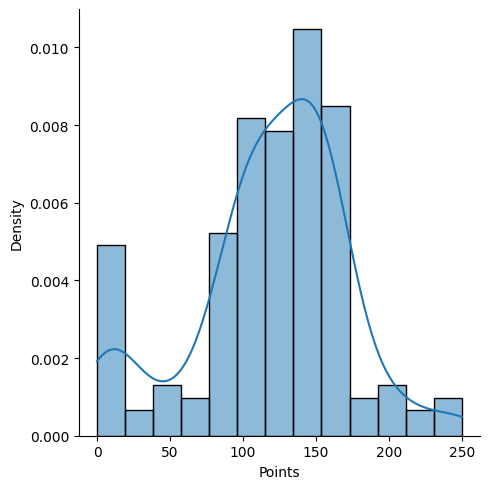

In [156]:
sns.displot(df["Points"], kde=True, stat="density")

plt.show()

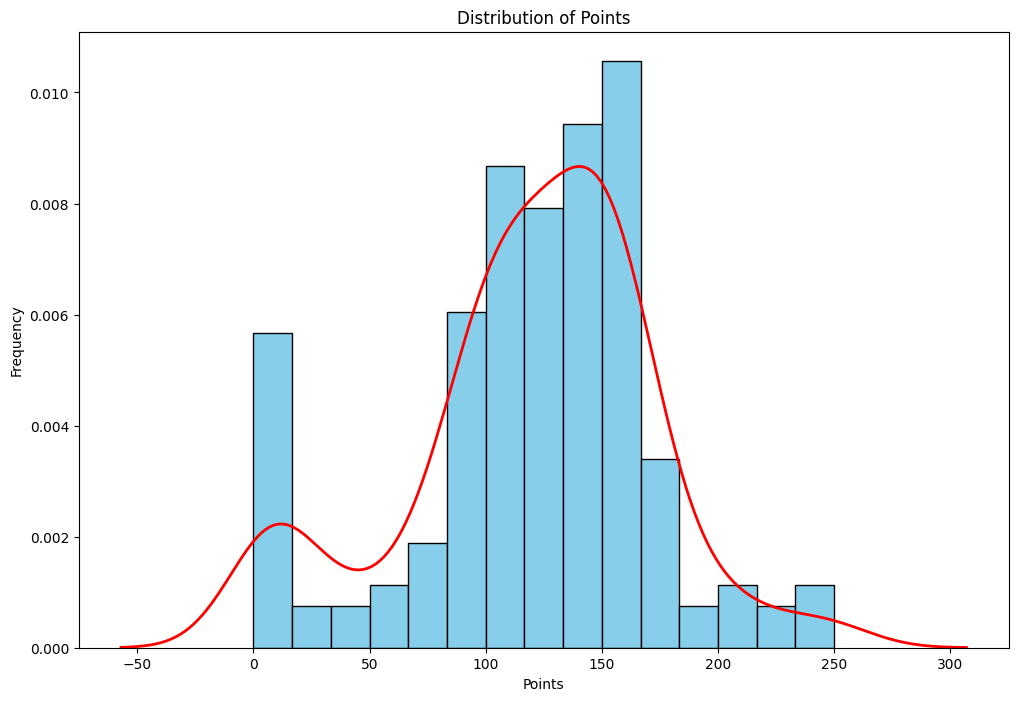

In [157]:
plt.hist(df["Points"], bins=15, color="skyblue", edgecolor="black", density=True)
plt.title('Distribution of Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
sns.kdeplot(data=df["Points"], color="red", linewidth=2)
plt.show()

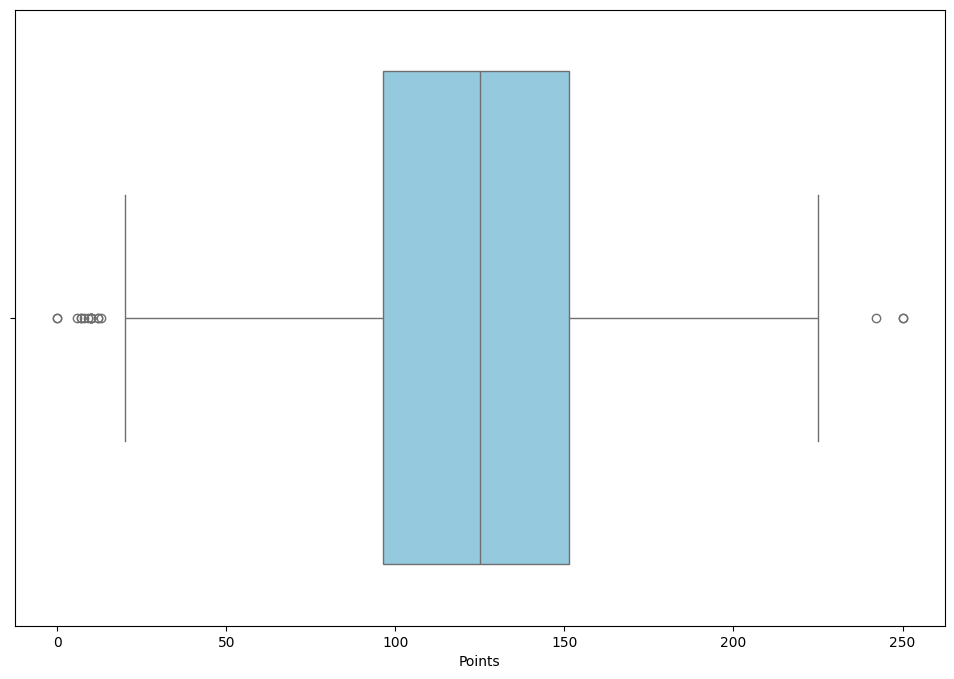

In [158]:
sns.boxplot(x=df["Points"], color="skyblue")

plt.show()

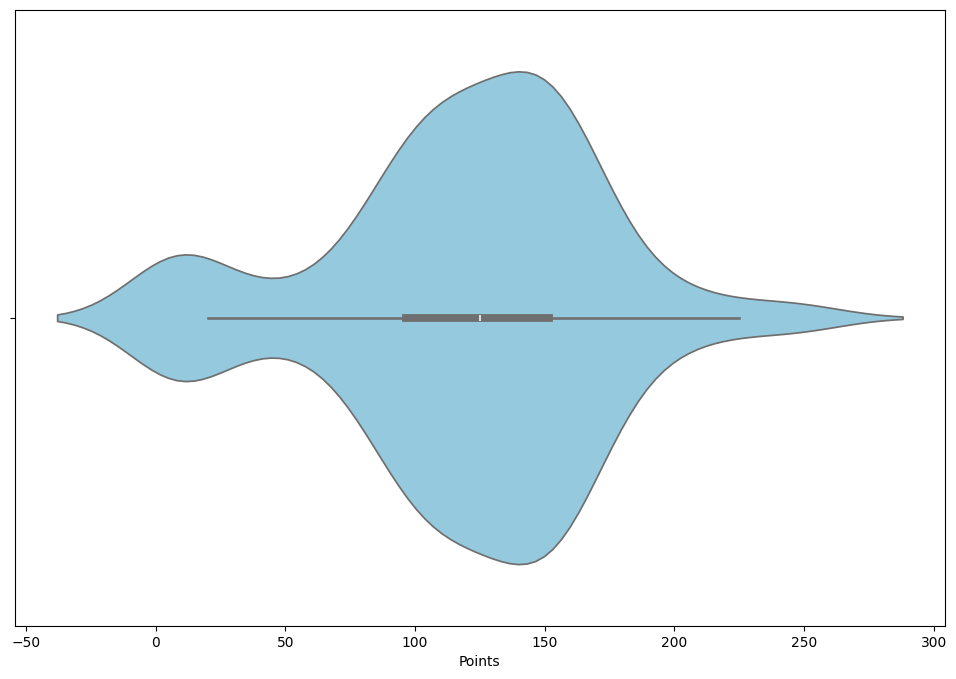

In [159]:
sns.violinplot(x=df["Points"], color="skyblue")
plt.show()

In [160]:
def plot_box_violin_plots(df, x, y):
    fig, ax = plt.subplots(1, 3, figsize=(18, 10))
    
    # Get the y-axis limits from the data
    y_min = df[y].min() - 10
    y_max = df[y].max() + 10
    
    fig.suptitle(f"Violin and box plots for variable {y} against {x}")
    
    # Create plots with consistent y-axis limits
    sns.boxplot(data=df[y], ax=ax[0])
    ax[0].set_ylim(y_min, y_max)
    ax[0].tick_params(axis='x', rotation=90)
    
    sns.boxplot(x=x, y=y, data=df, ax=ax[1], hue=x, palette="Set2")
    ax[1].set_ylim(y_min, y_max)
    ax[1].tick_params(axis='x', rotation=90)
    
    sns.violinplot(x=x, y=y, data=df, ax=ax[2], hue=x, palette="Set2")
    ax[2].set_ylim(y_min, y_max)
    ax[2].tick_params(axis='x', rotation=90)
    
    plt.tight_layout()
    plt.show()

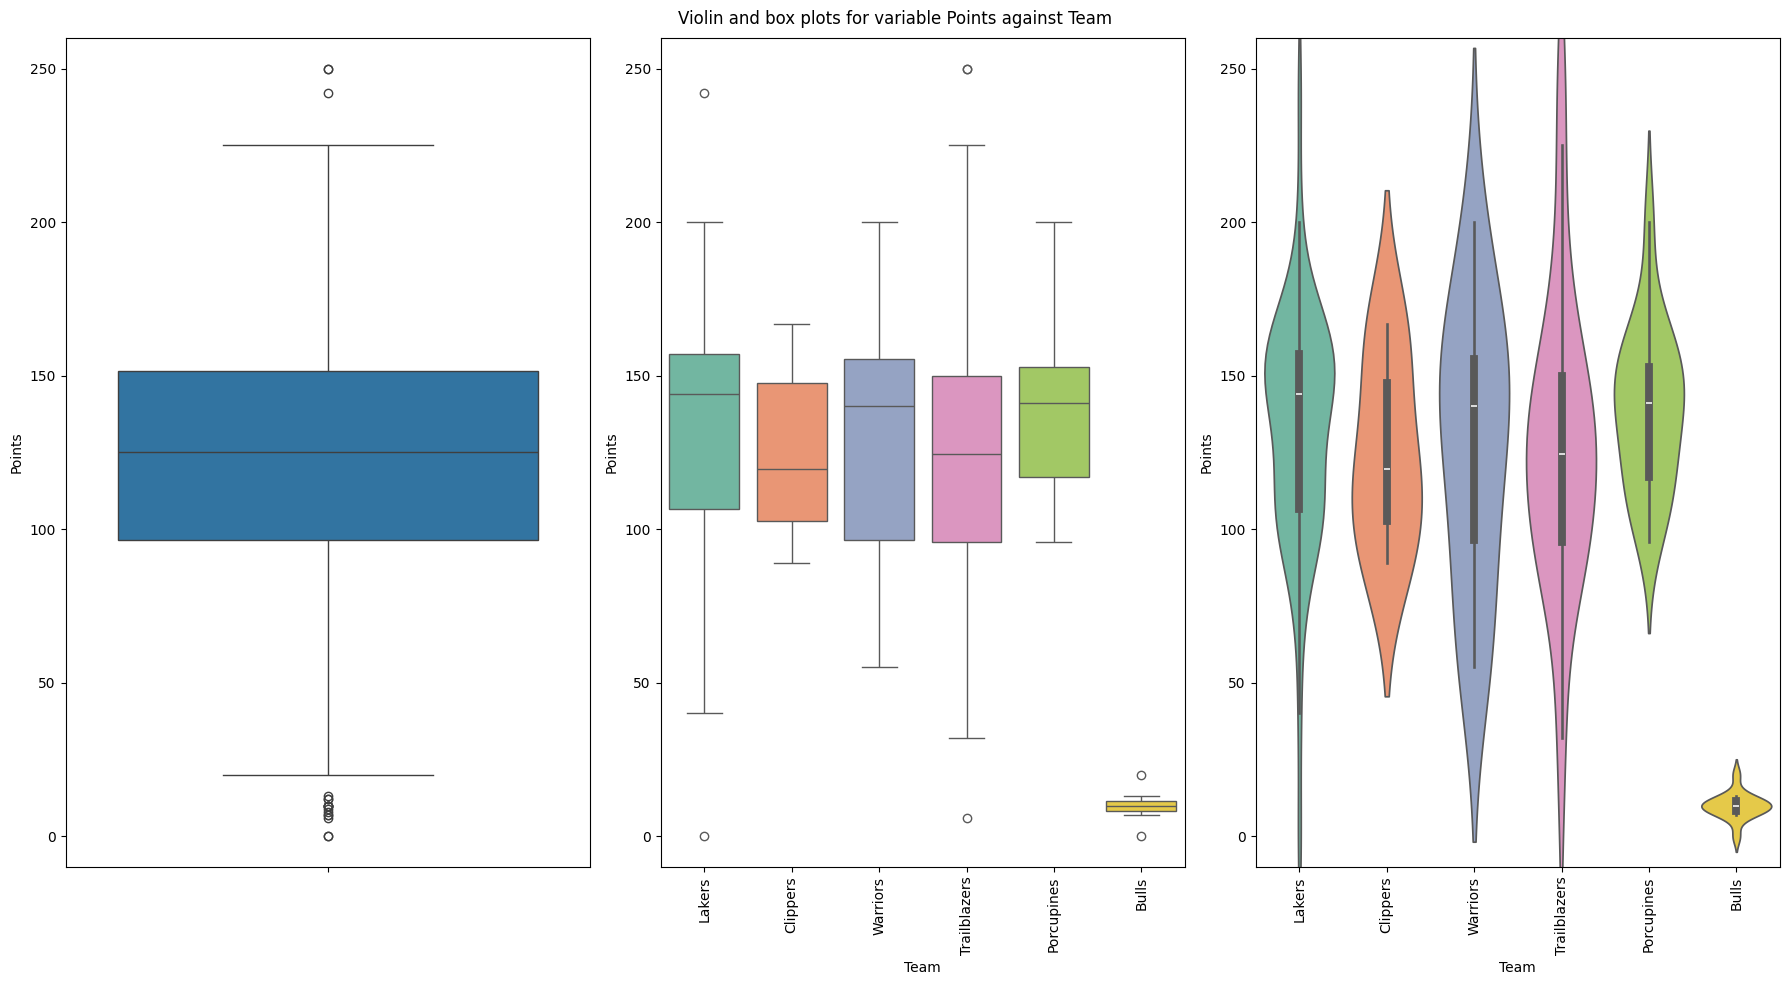

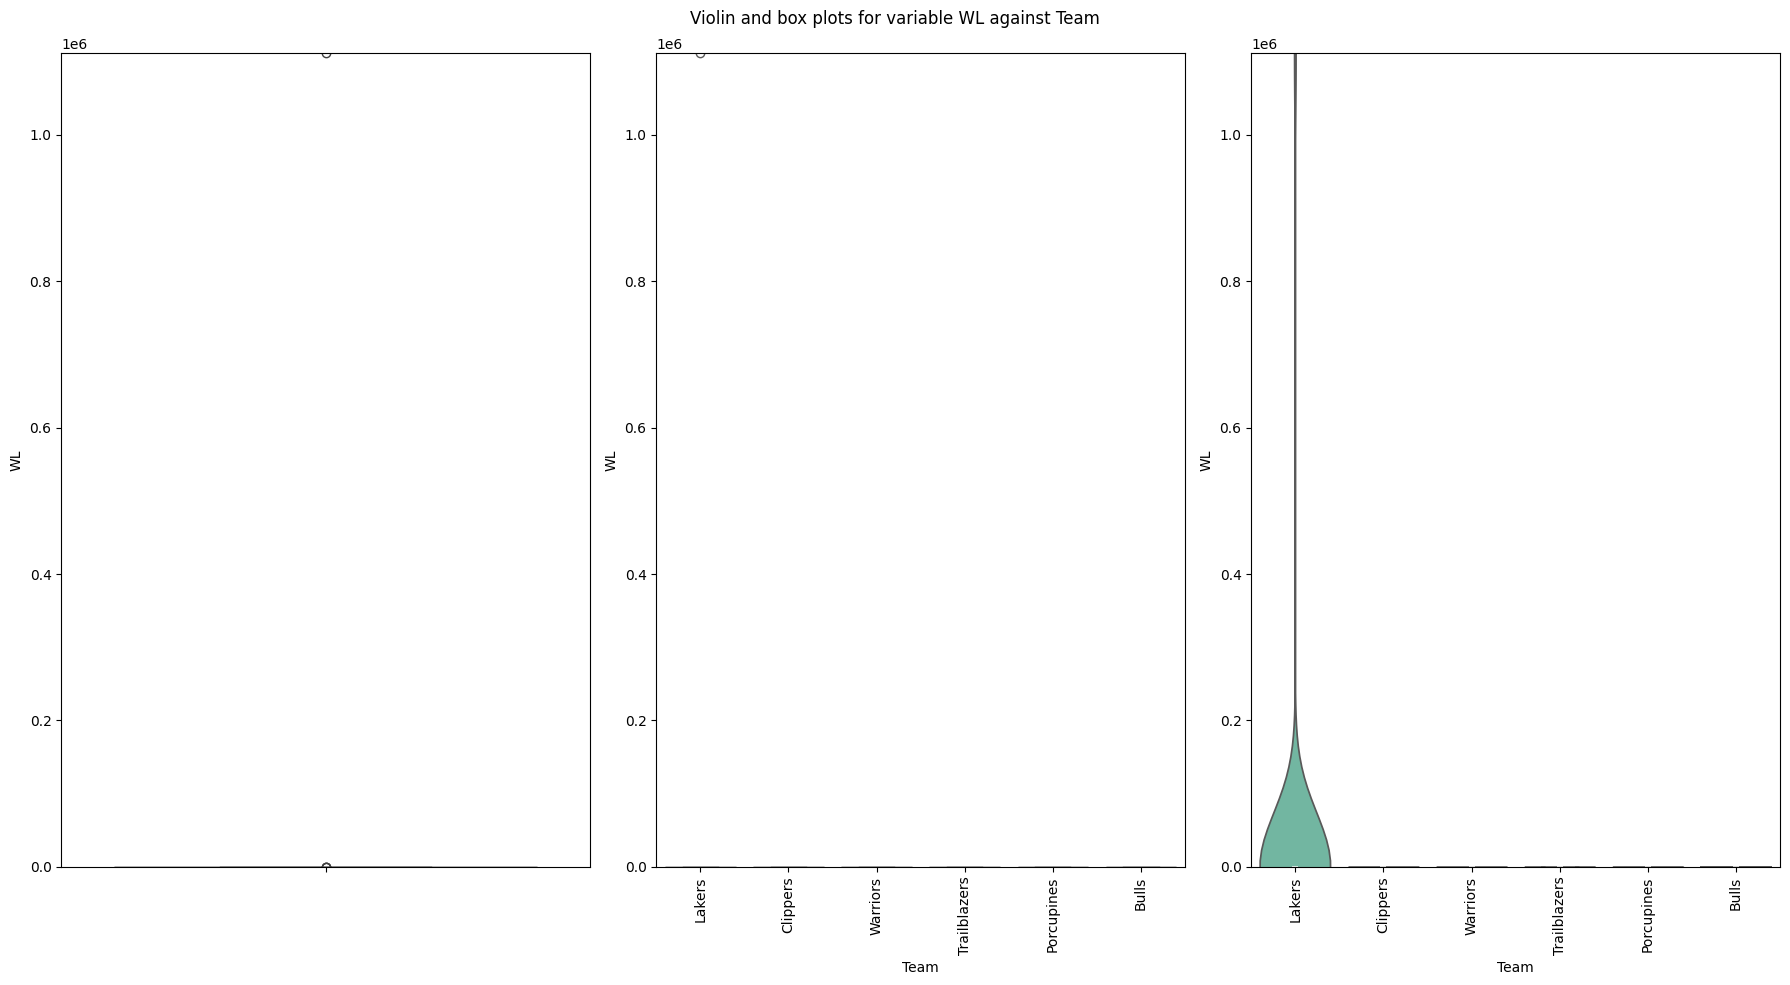

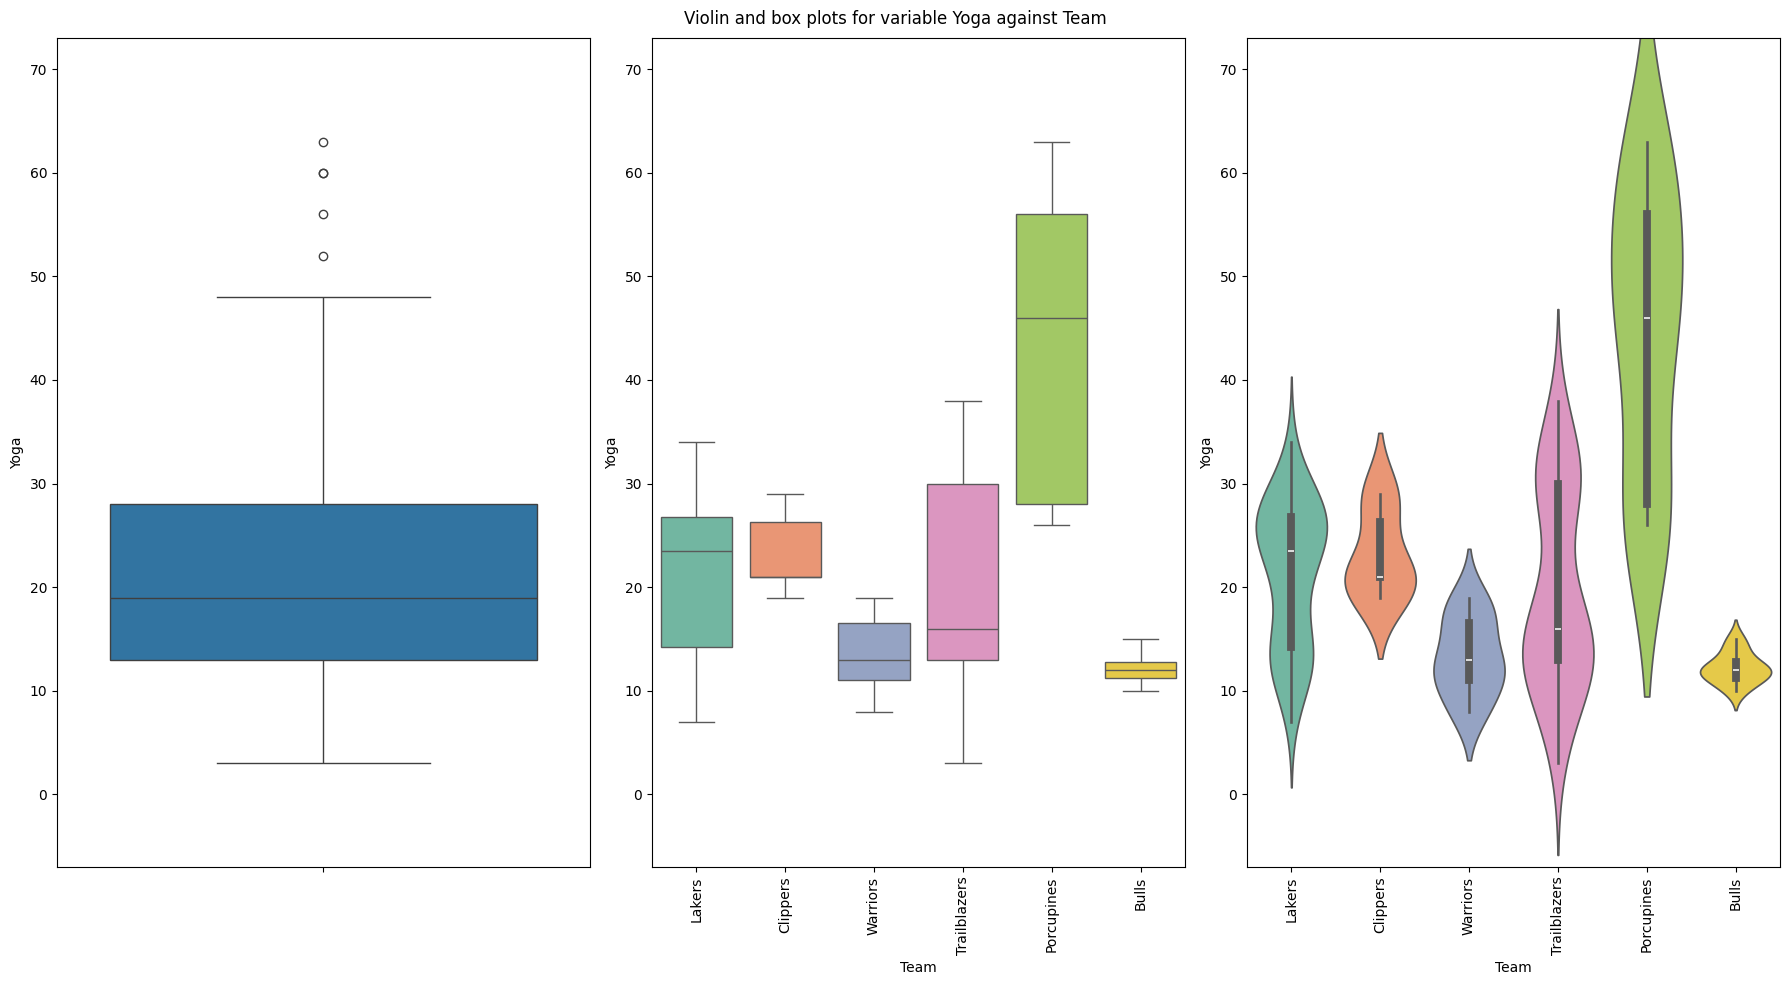

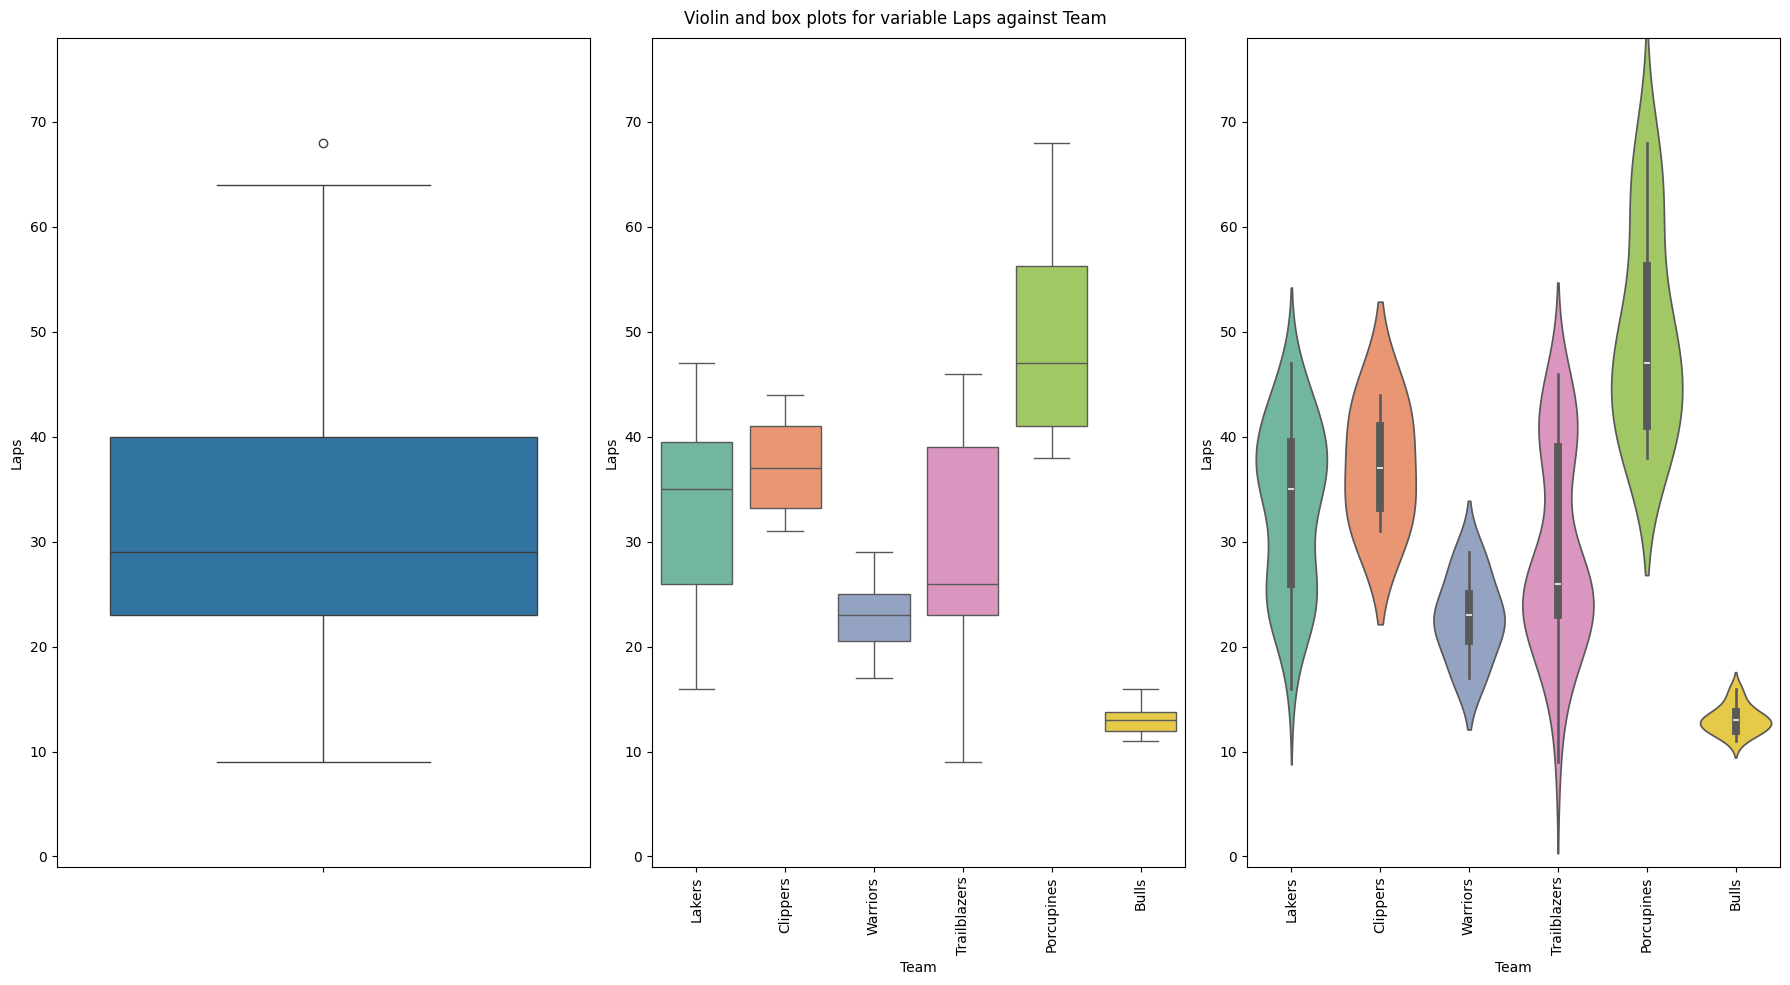

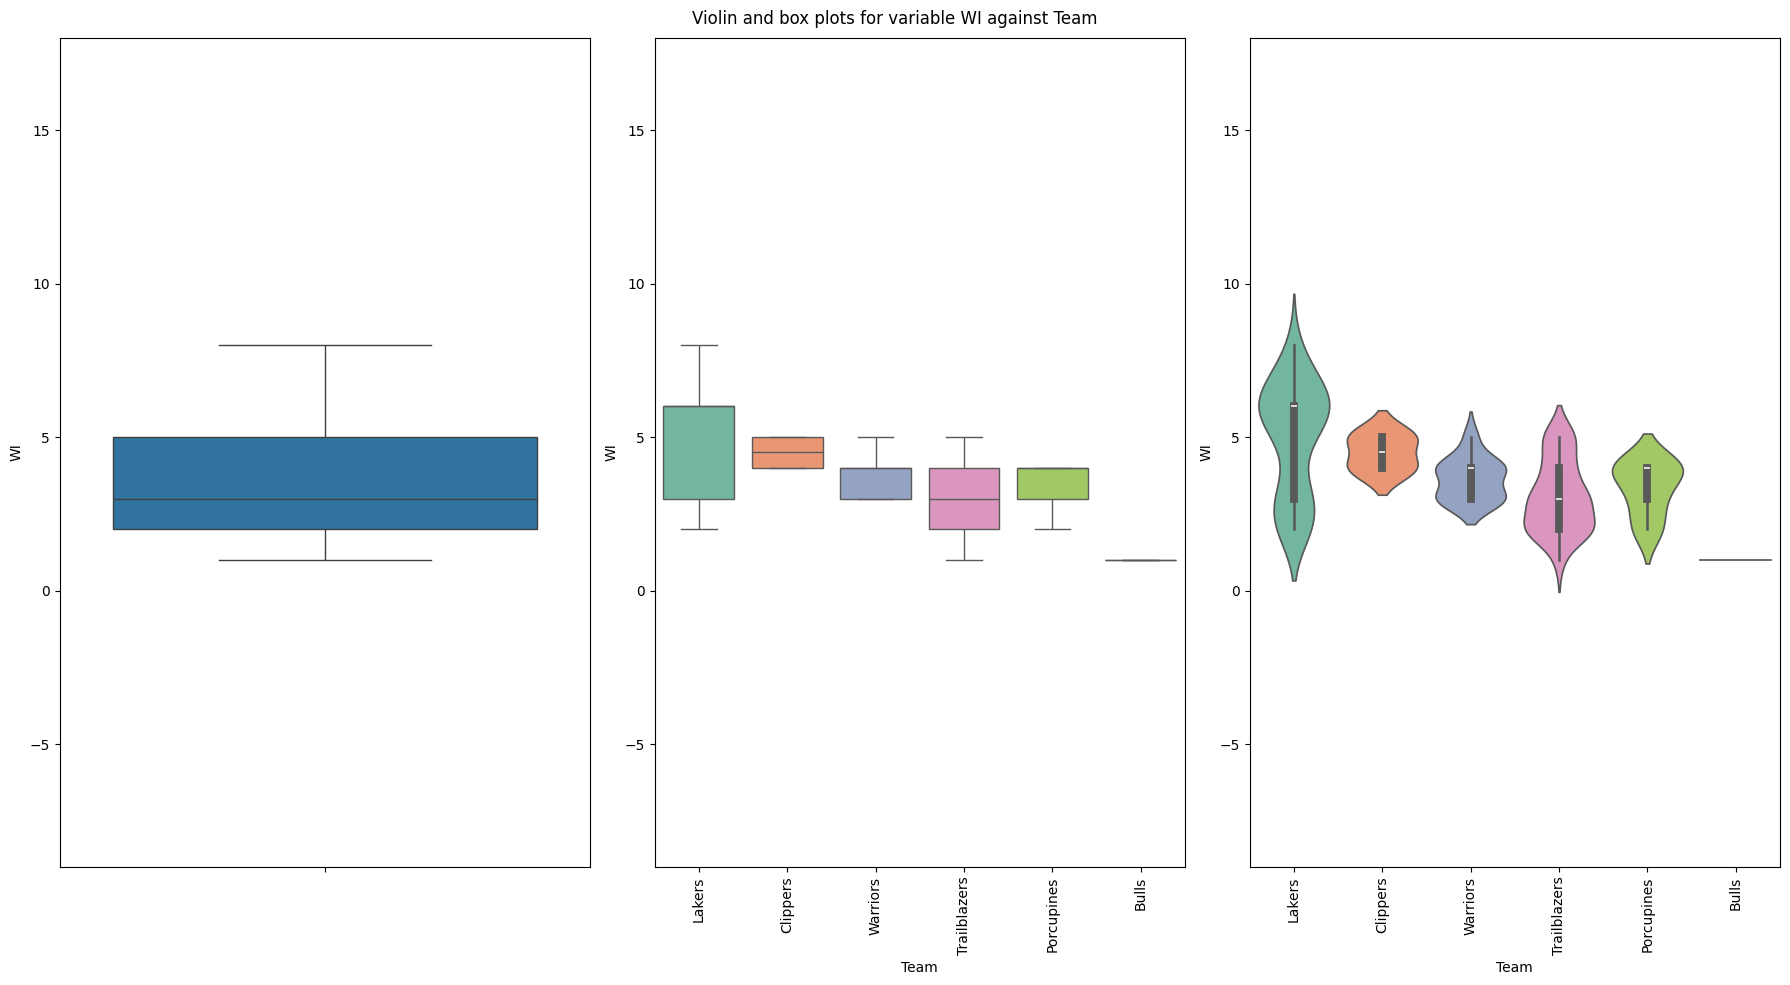

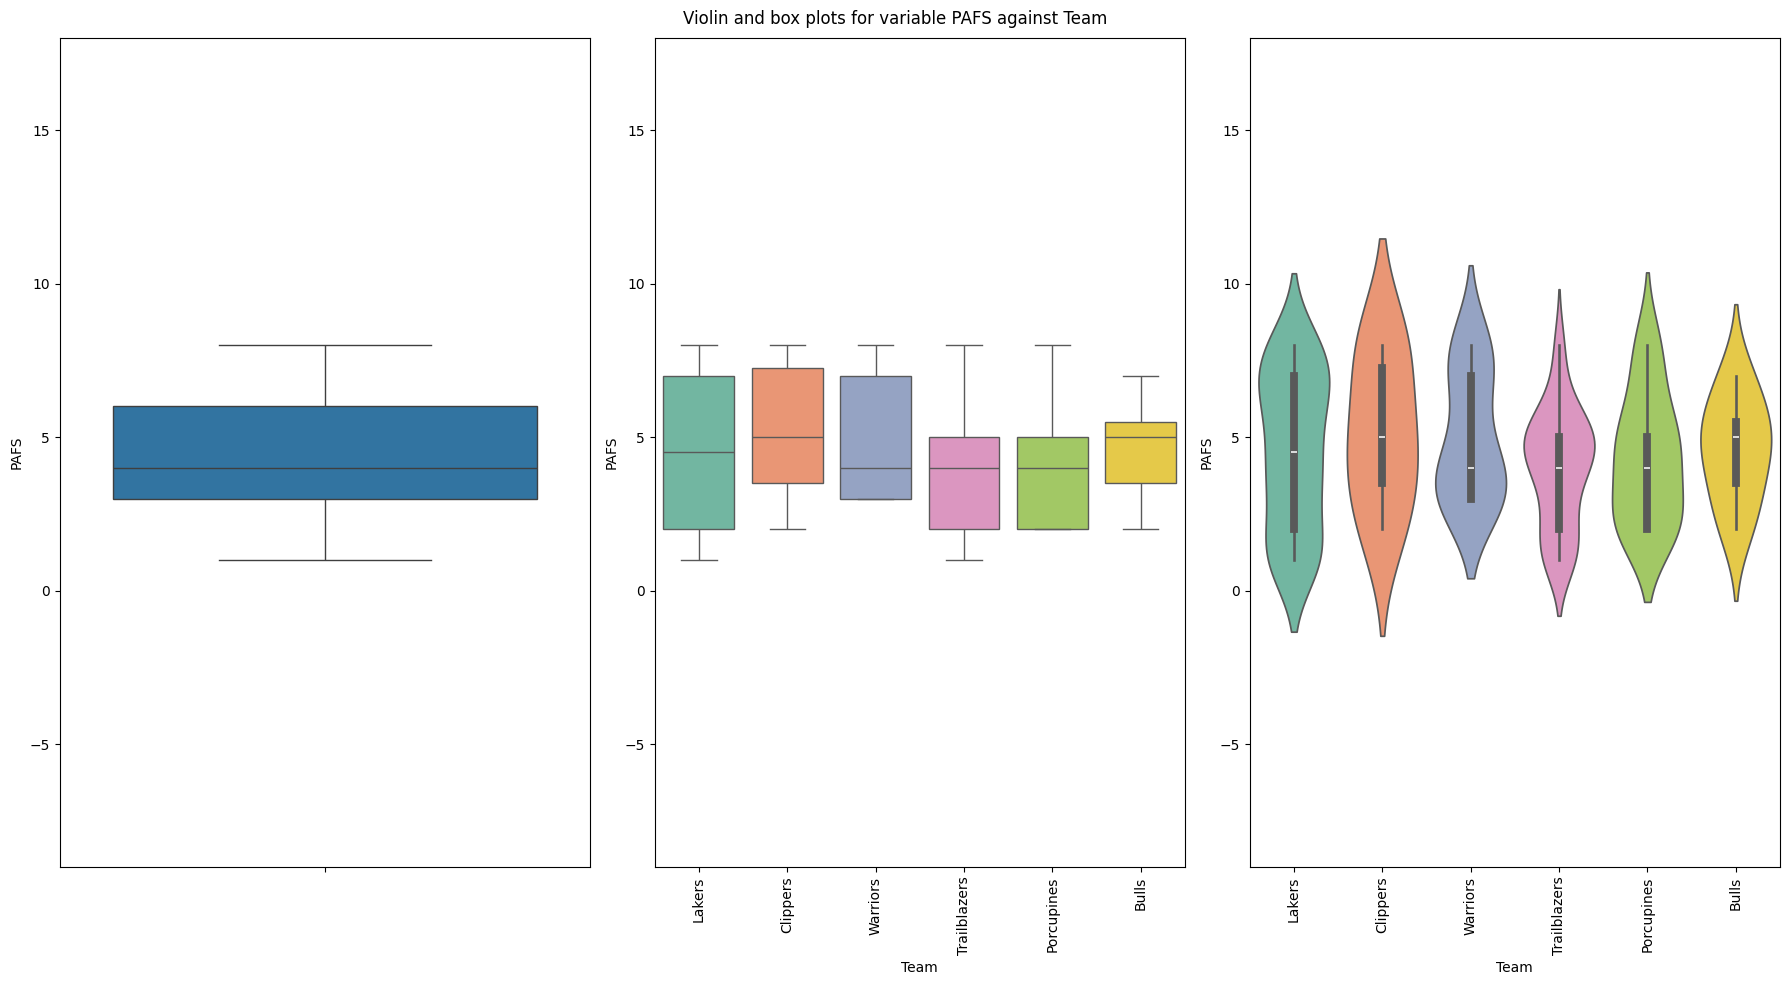

In [161]:
for col in df.columns:
    if col == "Team":
        continue
    plot_box_violin_plots(df, x="Team", y=col)

In [162]:
def find_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [163]:
for col in df.columns:
    if col == "Team":
        continue
    outliers = find_outliers(df, col)
    print(f"Outliers for column {col}:")
    print(outliers)
    print()

Outliers for column Points:
             Team  Points    WL  Yoga  Laps   WI  PAFS
0          Lakers     242  23.0  25.0  30.0  5.0   4.0
40         Lakers       0  19.0  13.0  23.0  3.0   7.0
72   Trailblazers       6   8.0   3.0   9.0  1.0   5.0
105  Trailblazers     250  25.0   NaN   NaN  3.0   NaN
106  Trailblazers     250  26.0   NaN   NaN  3.0   NaN
145         Bulls       7   9.0  10.0  11.0  1.0   2.0
146         Bulls       8  10.0  11.0  12.0  1.0   3.0
147         Bulls       7  10.0  11.0  12.0  1.0   4.0
148         Bulls      10  10.0   NaN  12.0  1.0   5.0
149         Bulls      10  11.0   NaN  12.0  1.0   7.0
150         Bulls       9  11.0   NaN  13.0  1.0   NaN
151         Bulls      10  11.0  12.0  13.0  1.0   NaN
152         Bulls      10  11.0  12.0  13.0  1.0   NaN
153         Bulls      10  11.0   NaN  13.0  1.0   NaN
154         Bulls      12  12.0  12.0  13.0  1.0   NaN
155         Bulls      13  12.0  12.0  14.0  1.0   NaN
156         Bulls      12  12.0  13.0

In [164]:
df_clean = df.drop(index=[142, 143, 144])

In [165]:
df_clean.loc[df_clean.index == 8, "WL"] = None

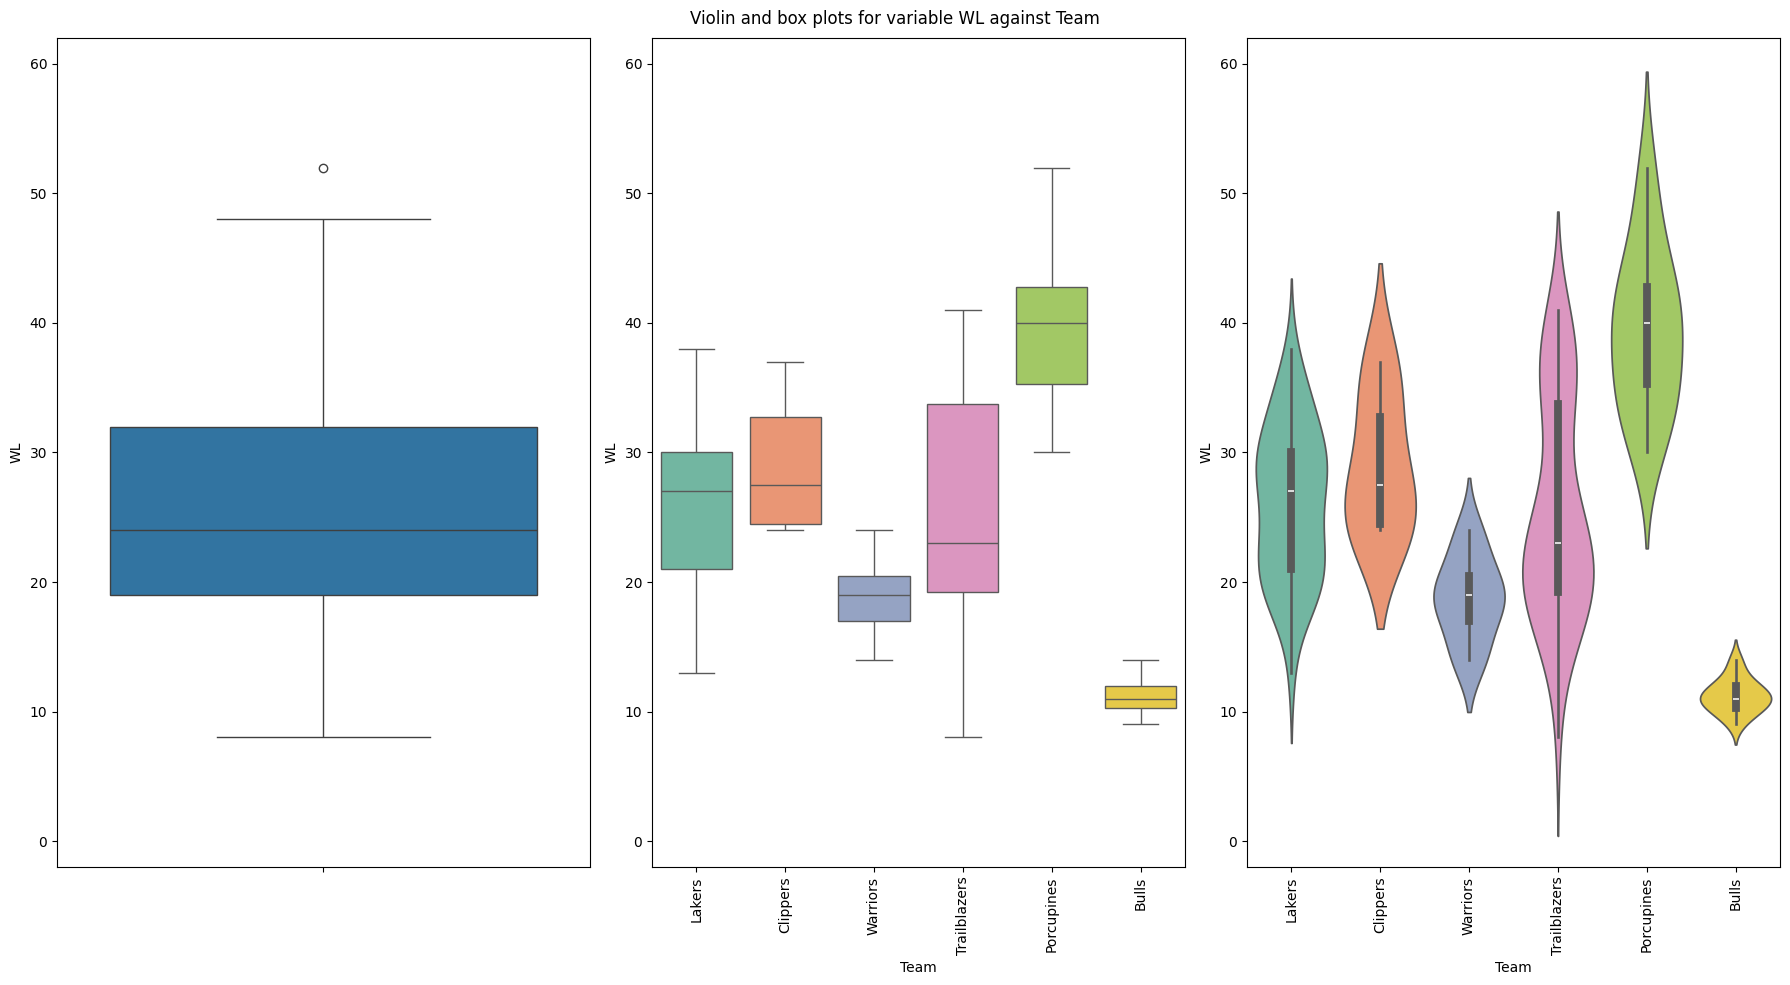

In [166]:
plot_box_violin_plots(df_clean, x="Team", y="WL")

#### Imputation Techniques

In [167]:
df_clean_simple = df_clean.copy()
df_clean_iterative = df_clean.copy()
df_clean_knn = df_clean.copy()

In [168]:
df_clean.isna().mean() # fraction of null values in each column - same as df_clean.isna().sum() / df_clean.shape[0]

Team      0.000000
Points    0.000000
WL        0.064103
Yoga      0.128205
Laps      0.089744
WI        0.089744
PAFS      0.185897
dtype: float64

In [169]:
null_counts = pd.DataFrame(df_clean.isna().sum() / df_clean.shape[0]).rename(columns={0: "Null_Proportion"})
null_counts

,Null_Proportion
Team,0.000000
Points,0.000000
WL,0.064103
Yoga,0.128205
Laps,0.089744
WI,0.089744
PAFS,0.185897


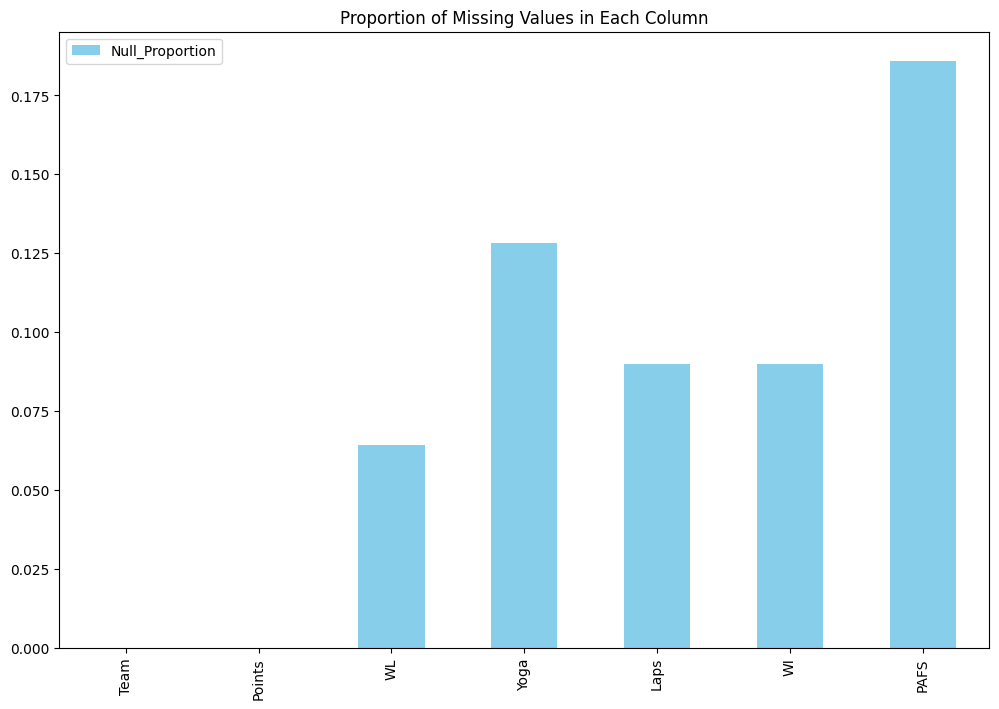

In [170]:
null_counts.plot(kind="bar", color="skyblue", title="Proportion of Missing Values in Each Column")
plt.show()

In [171]:
df_clean.shape, df_clean.dropna().shape

((156, 7), (94, 7))

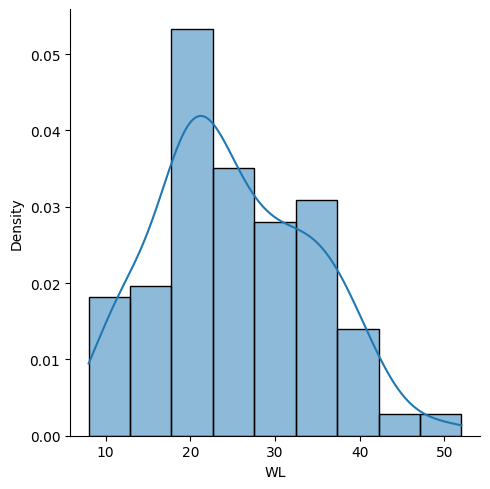

In [172]:
sns.displot(df_clean["WL"], kde=True, stat="density")
plt.show()

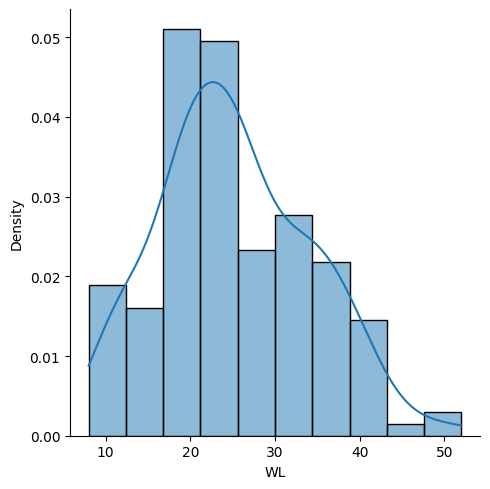

In [173]:
sns.displot(df_clean["WL"].fillna(df_clean["WL"].mean()), kde=True, stat="density") # naive approach using column mean
plt.show()

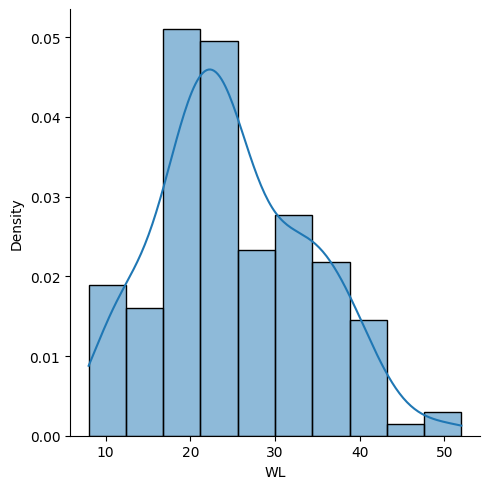

In [174]:
sns.displot(df_clean["WL"].fillna(df_clean["WL"].median()), kde=True, stat="density") # naive approach using column median
plt.show()

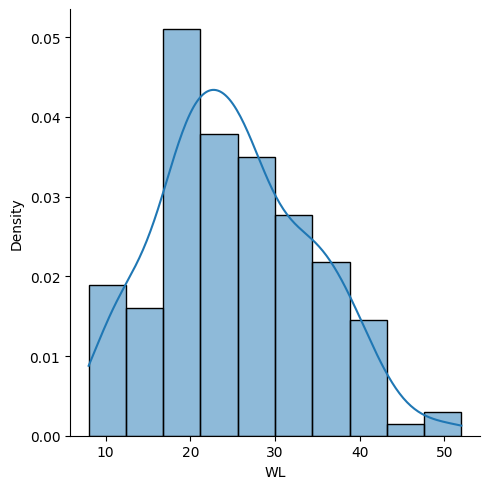

In [175]:
sns.displot(df_clean.fillna(df_clean.loc[:, ["Team", "WL", "Yoga", "Laps", "WI", "PAFS"]].groupby("Team").transform("mean"))["WL"], kde=True, stat="density")
plt.show()

In [176]:
df_clean.fillna(df_clean.loc[:, ["Team", "WL", "Yoga", "Laps", "WI", "PAFS"]].groupby("Team").transform("mean")) # naive approach but more refined because we are using group means (aggregates)

,Team,Points,WL,Yoga,Laps,WI,PAFS
0,Lakers,242,23.0,25.0,30.0,5.0,4.000000
1,Lakers,144,24.0,26.0,31.0,5.0,8.000000
2,Lakers,156,24.0,27.0,31.0,5.0,7.000000
3,Lakers,159,26.0,29.0,34.0,5.0,1.000000
4,Lakers,106,27.0,21.3,34.0,5.0,6.000000
...,...,...,...,...,...,...,...
154,Bulls,12,12.0,12.0,13.0,1.0,4.571429
155,Bulls,13,12.0,12.0,14.0,1.0,4.571429
156,Bulls,12,12.0,13.0,14.0,1.0,4.571429
157,Bulls,20,13.0,14.0,15.0,1.0,6.000000


##### Using Sklearn imputers

In [177]:
features = ["WL", "Yoga", "Laps", "WI", "PAFS"]
simple_imputer = SimpleImputer(strategy="mean")
df_clean_simple.loc[:, features] = simple_imputer.fit_transform(df_clean_simple.loc[:, features])

In [178]:
iterative_imputer = IterativeImputer(max_iter=10)
df_clean_iterative.loc[:, features] = iterative_imputer.fit_transform(df_clean_iterative.loc[:, features])

In [179]:
knn_imputer = KNNImputer(n_neighbors=5)
df_clean_knn.loc[:, features] = knn_imputer.fit_transform(df_clean_knn.loc[:, features])

In [180]:
df_clean_simple.loc[df_clean.loc[df_clean["WL"].isna()].index]

,Team,Points,WL,Yoga,Laps,WI,PAFS
8,Lakers,154,25.246575,20.823529,35.0,6.000000,8.0
18,Lakers,155,25.246575,28.000000,39.0,6.000000,4.0
19,Lakers,136,25.246575,23.000000,39.0,6.000000,6.0
20,Lakers,166,25.246575,24.000000,40.0,6.000000,8.0
21,Lakers,168,25.246575,25.000000,39.0,6.000000,1.0
22,Lakers,102,25.246575,26.000000,40.0,6.000000,6.0
23,Lakers,124,25.246575,25.000000,41.0,6.000000,6.0
33,Lakers,119,25.246575,34.000000,46.0,7.000000,1.0
117,Trailblazers,89,25.246575,31.000000,41.0,4.000000,1.0
122,Trailblazers,106,25.246575,30.000000,43.0,3.640845,4.0


In [181]:
df_clean_iterative.loc[df_clean.loc[df_clean["WL"].isna()].index]

,Team,Points,WL,Yoga,Laps,WI,PAFS
8,Lakers,154,27.769588,22.154644,35.0,6.000000,8.0
18,Lakers,155,31.759671,28.000000,39.0,6.000000,4.0
19,Lakers,136,31.553311,23.000000,39.0,6.000000,6.0
20,Lakers,166,32.439862,24.000000,40.0,6.000000,8.0
21,Lakers,168,31.772990,25.000000,39.0,6.000000,1.0
22,Lakers,102,32.561588,26.000000,40.0,6.000000,6.0
23,Lakers,124,33.457020,25.000000,41.0,6.000000,6.0
33,Lakers,119,37.676477,34.000000,46.0,7.000000,1.0
117,Trailblazers,89,35.421381,31.000000,41.0,4.000000,1.0
122,Trailblazers,106,35.957561,30.000000,43.0,5.464389,4.0


In [182]:
df_clean_knn.loc[df_clean.loc[df_clean["WL"].isna()].index]

,Team,Points,WL,Yoga,Laps,WI,PAFS
8,Lakers,154,26.8,20.8,35.0,6.0,8.0
18,Lakers,155,32.6,28.0,39.0,6.0,4.0
19,Lakers,136,30.0,23.0,39.0,6.0,6.0
20,Lakers,166,31.4,24.0,40.0,6.0,8.0
21,Lakers,168,32.8,25.0,39.0,6.0,1.0
22,Lakers,102,32.4,26.0,40.0,6.0,6.0
23,Lakers,124,32.0,25.0,41.0,6.0,6.0
33,Lakers,119,39.2,34.0,46.0,7.0,1.0
117,Trailblazers,89,31.2,31.0,41.0,4.0,1.0
122,Trailblazers,106,36.6,30.0,43.0,5.4,4.0


In [183]:
df_clean_iterative

,Team,Points,WL,Yoga,Laps,WI,PAFS
0,Lakers,242,23.0,25.000000,30.0,5.0,4.000000
1,Lakers,144,24.0,26.000000,31.0,5.0,8.000000
2,Lakers,156,24.0,27.000000,31.0,5.0,7.000000
3,Lakers,159,26.0,29.000000,34.0,5.0,1.000000
4,Lakers,106,27.0,22.063002,34.0,5.0,6.000000
...,...,...,...,...,...,...,...
154,Bulls,12,12.0,12.000000,13.0,1.0,4.413163
155,Bulls,13,12.0,12.000000,14.0,1.0,4.413298
156,Bulls,12,12.0,13.000000,14.0,1.0,4.413450
157,Bulls,20,13.0,14.000000,15.0,1.0,6.000000


#### Univariate analysis

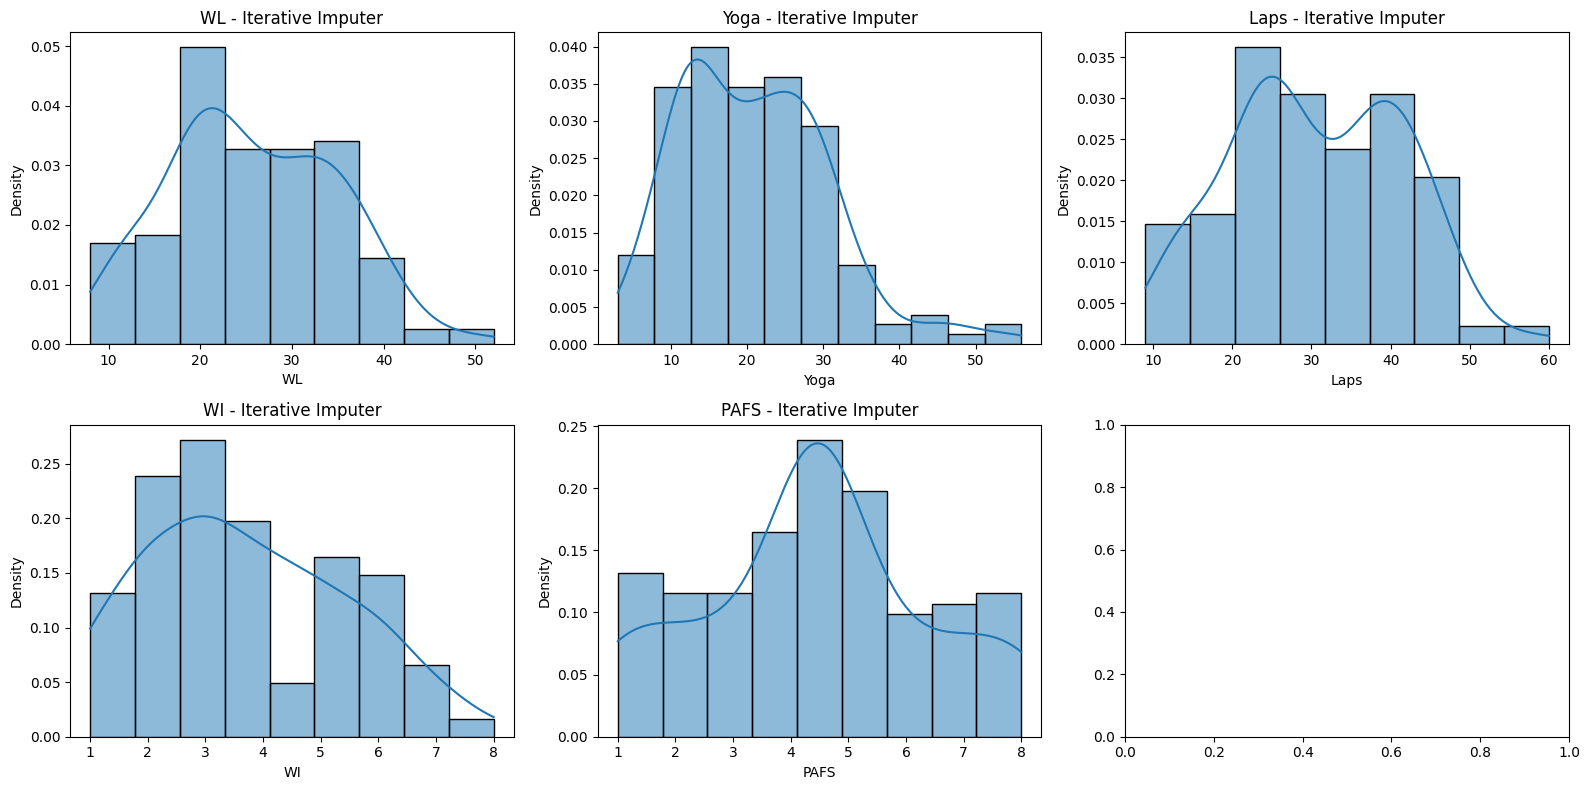

In [184]:
featrues = ["WL", "Yoga", "Laps", "WI", "PAFS"]

fig, ax = plt.subplots(2, 3, figsize=(16, 8))

sns.histplot(df_clean_iterative["WL"], kde=True, stat="density", ax=ax[0, 0])
ax[0, 0].set_title("WL - Iterative Imputer")

sns.histplot(df_clean_iterative["Yoga"], kde=True, stat="density", ax=ax[0, 1])
ax[0, 1].set_title("Yoga - Iterative Imputer")

sns.histplot(df_clean_iterative["Laps"], kde=True, stat="density", ax=ax[0, 2])
ax[0, 2].set_title("Laps - Iterative Imputer")

sns.histplot(df_clean_iterative["WI"], kde=True, stat="density", ax=ax[1, 0])
ax[1, 0].set_title("WI - Iterative Imputer")

sns.histplot(df_clean_iterative["PAFS"], kde=True, stat="density", ax=ax[1, 1])
ax[1, 1].set_title("PAFS - Iterative Imputer")

plt.tight_layout()
plt.show()


#### Exploring different values of bandwidth for kernel density estimation (lower values capture too much noise from individual data points and higher values end up over-smoothening sampled dataset thereby losing information)

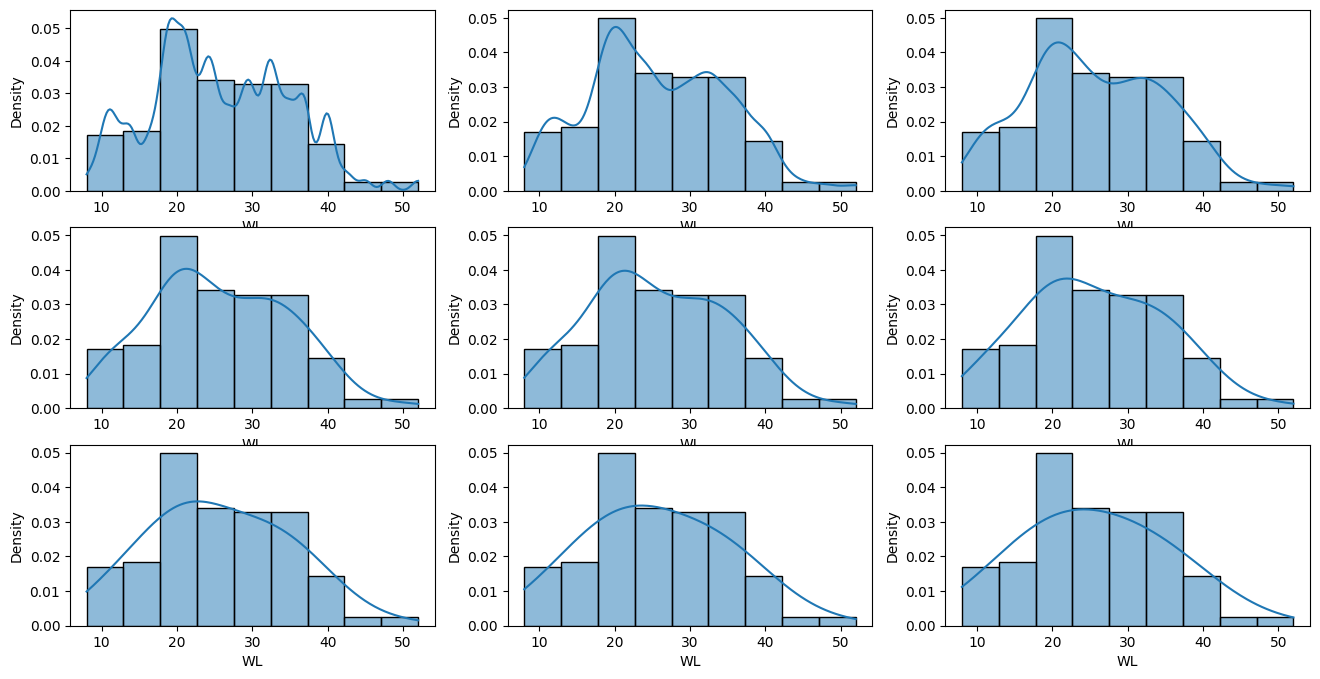

In [185]:
fig, ax = plt.subplots(3, 3, figsize=(16, 8))
sns.histplot(df_clean_knn["WL"], kde=True, stat="density", kde_kws={"bw_adjust": 0.25}, ax=ax[0, 0])
sns.histplot(df_clean_knn["WL"], kde=True, stat="density", kde_kws={"bw_adjust": 0.5}, ax=ax[0, 1])
sns.histplot(df_clean_knn["WL"], kde=True, stat="density", kde_kws={"bw_adjust": 0.75}, ax=ax[0, 2])
sns.histplot(df_clean_knn["WL"], kde=True, stat="density", kde_kws={"bw_adjust": 0.95}, ax=ax[1, 0])
sns.histplot(df_clean_knn["WL"], kde=True, stat="density", kde_kws={"bw_adjust": 1}, ax=ax[1, 1])
sns.histplot(df_clean_knn["WL"], kde=True, stat="density", kde_kws={"bw_adjust": 1.25}, ax=ax[1, 2])
sns.histplot(df_clean_knn["WL"], kde=True, stat="density", kde_kws={"bw_adjust": 1.5}, ax=ax[2, 0])
sns.histplot(df_clean_knn["WL"], kde=True, stat="density", kde_kws={"bw_adjust": 1.75}, ax=ax[2, 1])
sns.histplot(df_clean_knn["WL"], kde=True, stat="density", kde_kws={"bw_adjust": 2}, ax=ax[2, 2])
plt.show()

In [186]:
df_clean_iterative.corr(numeric_only=True)

,Points,WL,Yoga,Laps,WI,PAFS
Points,1.000000,0.452880,0.367989,0.470764,0.438719,0.067236
WL,0.452880,1.000000,0.948144,0.990977,0.718120,0.003059
Yoga,0.367989,0.948144,1.000000,0.935172,0.624450,0.021876
Laps,0.470764,0.990977,0.935172,1.000000,0.788834,0.018003
WI,0.438719,0.718120,0.624450,0.788834,1.000000,0.064468
PAFS,0.067236,0.003059,0.021876,0.018003,0.064468,1.000000


In [187]:
for i in df["Team"].unique():
    print("--------------------")
    print(f"Correlation matrix for team {i}")
    display(df_clean_iterative.loc[df_clean_iterative["Team"] == i].corr(numeric_only=True))
    print("--------------------")

--------------------
Correlation matrix for team Lakers


,Points,WL,Yoga,Laps,WI,PAFS
Points,1.000000,0.179344,0.270497,0.202754,0.210512,0.127101
WL,0.179344,1.000000,0.900836,0.992771,0.935198,0.071960
Yoga,0.270497,0.900836,1.000000,0.914778,0.893825,0.057310
Laps,0.202754,0.992771,0.914778,1.000000,0.958420,0.070569
WI,0.210512,0.935198,0.893825,0.958420,1.000000,0.117071
PAFS,0.127101,0.071960,0.057310,0.070569,0.117071,1.000000


--------------------
--------------------
Correlation matrix for team Clippers


,Points,WL,Yoga,Laps,WI,PAFS
Points,1.000000,0.378763,0.169838,0.362844,0.562174,-0.684177
WL,0.378763,1.000000,0.915736,0.998901,0.968636,-0.710559
Yoga,0.169838,0.915736,1.000000,0.924402,0.891602,-0.423548
Laps,0.362844,0.998901,0.924402,1.000000,0.965704,-0.709447
WI,0.562174,0.968636,0.891602,0.965704,1.000000,-0.726760
PAFS,-0.684177,-0.710559,-0.423548,-0.709447,-0.726760,1.000000


--------------------
--------------------
Correlation matrix for team Warriors


,Points,WL,Yoga,Laps,WI,PAFS
Points,1.000000,0.687517,0.635169,0.693264,0.656408,0.189237
WL,0.687517,1.000000,0.903716,0.995374,0.815192,0.643726
Yoga,0.635169,0.903716,1.000000,0.905081,0.667608,0.665418
Laps,0.693264,0.995374,0.905081,1.000000,0.822281,0.687596
WI,0.656408,0.815192,0.667608,0.822281,1.000000,0.494975
PAFS,0.189237,0.643726,0.665418,0.687596,0.494975,1.000000


--------------------
--------------------
Correlation matrix for team Trailblazers


,Points,WL,Yoga,Laps,WI,PAFS
Points,1.000000,0.211886,0.217783,0.216185,0.202055,0.127929
WL,0.211886,1.000000,0.980483,0.997325,0.952565,-0.089945
Yoga,0.217783,0.980483,1.000000,0.977904,0.930629,-0.109504
Laps,0.216185,0.997325,0.977904,1.000000,0.953129,-0.083704
WI,0.202055,0.952565,0.930629,0.953129,1.000000,-0.094311
PAFS,0.127929,-0.089945,-0.109504,-0.083704,-0.094311,1.000000


--------------------
--------------------
Correlation matrix for team Porcupines


,Points,WL,Yoga,Laps,WI,PAFS
Points,1.000000,-0.335413,-0.151303,-0.359885,-0.573253,0.088876
WL,-0.335413,1.000000,0.965736,0.996279,0.264736,0.501578
Yoga,-0.151303,0.965736,1.000000,0.957211,0.183906,0.557358
Laps,-0.359885,0.996279,0.957211,1.000000,0.285326,0.528586
WI,-0.573253,0.264736,0.183906,0.285326,1.000000,-0.033829
PAFS,0.088876,0.501578,0.557358,0.528586,-0.033829,1.000000


--------------------
--------------------
Correlation matrix for team Bulls


,Points,WL,Yoga,Laps,WI,PAFS
Points,1.000000,0.115133,0.031397,0.082858,NaN,0.328588
WL,0.115133,1.000000,0.582780,0.962222,NaN,0.539512
Yoga,0.031397,0.582780,1.000000,0.626450,NaN,-0.122909
Laps,0.082858,0.962222,0.626450,1.000000,NaN,0.412531
WI,NaN,NaN,NaN,NaN,NaN,NaN
PAFS,0.328588,0.539512,-0.122909,0.412531,NaN,1.000000


--------------------


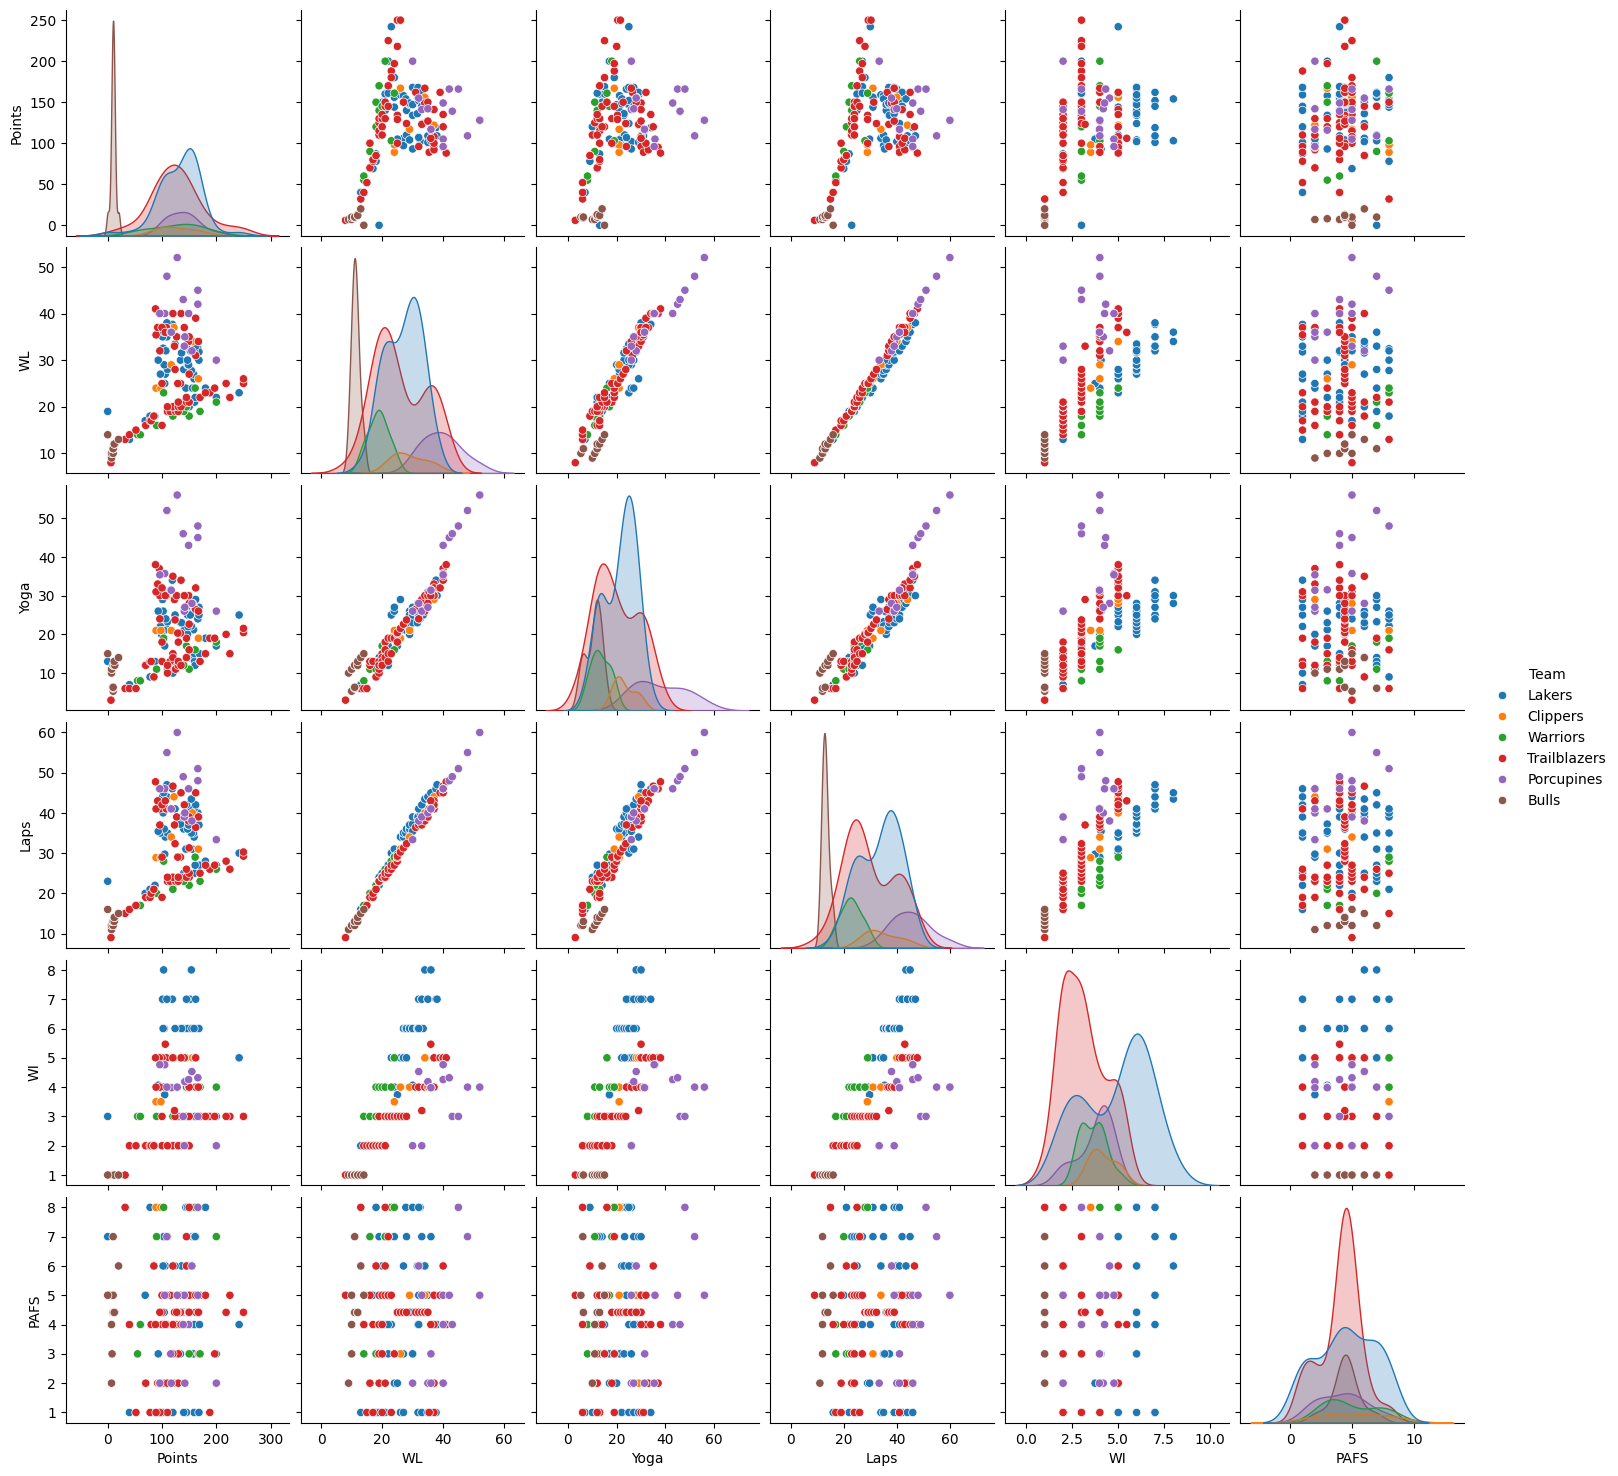

In [188]:
sns.pairplot(df_clean_iterative, kind="scatter", hue="Team")
plt.show()

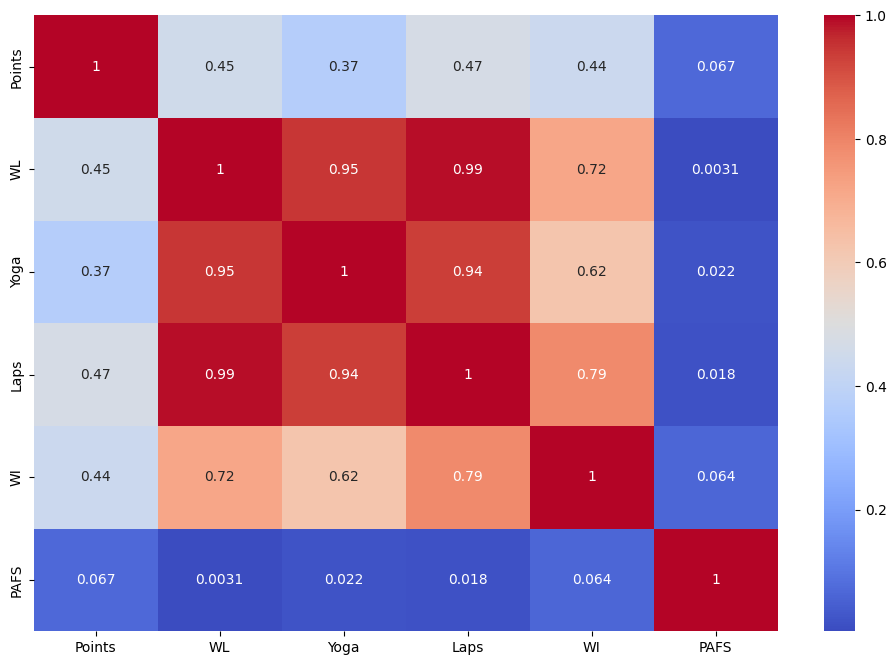

In [189]:
plt.rcParams["figure.figsize"] = (12, 8)
sns.heatmap(df_clean_iterative.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()

#### Computation of Chatterjee Correlation Coefficient which verifies non-linear dependence (function) between two variables

In [190]:
compute_chatterjee_corr_df(df_clean_iterative, x="WL", y="Points")

0.34218204232586813

In [191]:
compute_chatterjee_corr_np(df_clean_iterative["WL"].values, df_clean_iterative["Points"].values)

0.34313716206619005

In [192]:
compute_chatterjee_corr_df(df_clean_iterative, x="WI", y="Points")

0.326587220053421

In [193]:
compute_chatterjee_corr_np(df_clean_iterative["WI"].values, df_clean_iterative["Points"].values)

0.3275649827186212

In [194]:
compute_chatterjee_corr_df(df_clean_iterative, x="Laps", y="Points")

0.4205876309841792

In [195]:
compute_chatterjee_corr_np(df_clean_iterative["Laps"].values, df_clean_iterative["Points"].values)

0.421428909616022

In [196]:
compute_chatterjee_corr_df(df_clean_iterative, x="PAFS", y="Points")

0.26920073967536473

In [197]:
compute_chatterjee_corr_np(df_clean_iterative["PAFS"].values, df_clean_iterative["Points"].values)

0.2702618247242081

In [198]:
compute_chatterjee_corr_df(df_clean_iterative, x="Yoga", y="Points")

0.18463118964454495

In [199]:
compute_chatterjee_corr_np(df_clean_iterative["Yoga"].values, df_clean_iterative["Points"].values)

0.18581506557454663

In [200]:
df_clean

,Team,Points,WL,Yoga,Laps,WI,PAFS
0,Lakers,242,23.0,25.0,30.0,5.0,4.0
1,Lakers,144,24.0,26.0,31.0,5.0,8.0
2,Lakers,156,24.0,27.0,31.0,5.0,7.0
3,Lakers,159,26.0,29.0,34.0,5.0,1.0
4,Lakers,106,27.0,NaN,34.0,5.0,6.0
...,...,...,...,...,...,...,...
154,Bulls,12,12.0,12.0,13.0,1.0,NaN
155,Bulls,13,12.0,12.0,14.0,1.0,NaN
156,Bulls,12,12.0,13.0,14.0,1.0,NaN
157,Bulls,20,13.0,14.0,15.0,1.0,6.0


In [201]:
one_hot_df = pd.get_dummies(data=df_clean, columns=["Team"], dtype="int", drop_first=True)

In [202]:
X = one_hot_df.drop(columns=["Points"])
y = one_hot_df["Points"]

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [204]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((124, 10), (32, 10), (124,), (32,))

In [205]:
features = X_train.columns
iterative_imputer = IterativeImputer(max_iter=10)
X_train.loc[:, features] = iterative_imputer.fit_transform(X_train)

In [206]:
X_train

,WL,Yoga,Laps,WI,PAFS,Team_Clippers,Team_Lakers,Team_Porcupines,Team_Trailblazers,Team_Warriors
56,24.0,21.000000,28.663468,3.422326,8.000000,1,0,0,0,0
138,43.0,46.000000,49.000000,3.000000,4.000000,0,0,1,0,0
123,39.0,32.000000,45.000000,5.000000,5.000000,0,0,0,1,0
128,30.0,26.000000,35.168711,2.000000,2.000000,0,0,1,0,0
127,41.0,38.000000,46.857489,5.000000,4.000000,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
71,24.0,16.000000,29.000000,5.000000,8.000000,0,0,0,0,1
106,26.0,19.821783,29.789593,3.000000,4.358999,0,0,0,1,0
14,29.0,22.000000,37.000000,6.000000,4.359124,0,1,0,0,0
92,21.0,16.000000,24.000000,3.000000,5.000000,0,0,0,1,0


#### OLS with intercept using statsmodels

In [207]:
lr1 = sm.OLS(y_train, sm.add_constant(X_train)).fit()
lr1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     10.32
Date:                Tue, 07 Jan 2025   Prob (F-statistic):           3.38e-12
Time:                        07:00:57   Log-Likelihood:                -628.31
No. Observations:                 124   AIC:                             1279.
Df Residuals:                     113   BIC:                             1310.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -5.6177     17.738     -0.317      0.752     -40.760      29.525
WL                   -8.5455      6.231     -1.371      0.173     -20.890       3.799
Yoga                  0.2907      1.498      0.194      0.847      -2.678       3.259
Laps                  8.5142      6.090      1.398      0.165      -3.552      20.580
WI                   -2.2930      8.369     -0.274      0.785     -18.873      14.287
PAFS                 -0.2458      1.915     -0.128      0.898      -4.039       3.548
Team_Clippers        95.5431     27.008      3.538      0.001      42.036     149.050
Team_Lakers          86.9643     21.116      4.118      0.000      45.129     128.800
Team_Porcupines      88.8252     33.400      2.659      0.009      22.654     154.997
Team_Trailblazers    97.5256     19.504      5.000      0.000      58.885     136.166
Team_Warriors        95.3772     22.509      4.237      0.000      50.784     139.971
==============================================================================
Omnibus:                       12.302   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.516
Skew:                           0.514   Prob(JB):                     0.000157
Kurtosis:                       4.527   Cond. No.                         592.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### OLS without intercept using statsmodels

In [208]:
lr2 = sm.OLS(y_train, X_train).fit()
lr2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Points   R-squared (uncentered):                   0.909
Model:                            OLS   Adj. R-squared (uncentered):              0.901
Method:                 Least Squares   F-statistic:                              113.4
Date:                Tue, 07 Jan 2025   Prob (F-statistic):                    2.08e-54
Time:                        07:00:57   Log-Likelihood:                         -628.36
No. Observations:                 124   AIC:                                      1277.
Df Residuals:                     114   BIC:                                      1305.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
WL                   -8.1296      6.067     -1.340      0.183     -20.148       3.889
Yoga                  0.3096      1.491      0.208      0.836      -2.644       3.264
Laps                  7.9033      5.754      1.374      0.172      -3.495      19.302
WI                   -1.0111      7.296     -0.139      0.890     -15.464      13.442
PAFS                 -0.5618      1.628     -0.345      0.731      -3.786       2.663
Team_Clippers        94.6705     26.761      3.538      0.001      41.658     147.683
Team_Lakers          85.3690     20.426      4.179      0.000      44.906     125.832
Team_Porcupines      91.6627     32.049      2.860      0.005      28.175     155.151
Team_Trailblazers    96.3308     19.060      5.054      0.000      58.573     134.088
Team_Warriors        92.4290     20.412      4.528      0.000      51.992     132.866
==============================================================================
Omnibus:                       12.184   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               17.469
Skew:                           0.506   Prob(JB):                     0.000161
Kurtosis:                       4.535   Cond. No.                         592.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Model fit with intercept using scikit learn

In [209]:
model = LinearRegression()
model.fit(X=X_train, y=y_train)

LinearRegression()

In [210]:
X_test.loc[:, features] = iterative_imputer.transform(X_test)

In [211]:
y_test_pred = model.predict(X_test)

In [212]:
y_test_pred.shape, y_test.shape

((32,), (32,))

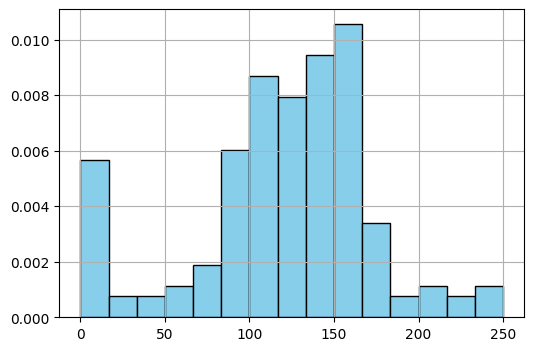

In [213]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
df["Points"].hist(bins=15, color="skyblue", edgecolor="black", density=True, ax=ax)
plt.show()

In [215]:
df["Points"].mean(), df["Points"].median()

(np.float64(119.32704402515724), np.float64(125.0))

In [216]:
mean_absolute_error(y_test, lr1.predict(sm.add_constant(X_test))) # MAE for model with predictions using statsmodels  api

np.float64(31.20629235950195)

In [217]:
mean_absolute_error(y_test, y_test_pred) # MAE for model with predictions using sklearn api

np.float64(31.206292359501955)

In [219]:
np.sum(np.abs(y_test - y_test_pred)) / y_test.shape[0] # MAE for model using numpy manual computations and predictions from sklearn api

np.float64(31.206292359501955)

In [220]:
mean_squared_error(y_test, lr1.predict(sm.add_constant(X_test))) # MSE for model with predictions using statsmodels api

np.float64(1731.137688470608)

In [221]:
mean_squared_error(y_test, y_test_pred) # MSE for model with predictions using sklearn api

np.float64(1731.1376884706065)

In [222]:
np.sum((y_test - y_test_pred) ** 2) / y_test.shape[0] # mean squared error for model using numpy manual computations and predictions sklearn api

np.float64(1731.1376884706065)

In [223]:
root_mean_squared_error(y_test, lr1.predict(sm.add_constant(X_test))) # RMSE for model with predictions using statsmodels api

np.float64(41.60694279168572)

In [224]:
root_mean_squared_error(y_test, y_test_pred) # RMSE for model with predictions using sklearn api

np.float64(41.6069427916857)

In [225]:
np.sqrt(np.sum((y_test - y_test_pred) ** 2) / y_test.shape[0]) # root mean squared error for model using numpy manual computations and predictions sklearn api

np.float64(41.6069427916857)

In [226]:
root_mean_squared_error(y_test, y_test_pred) / np.mean(df["Points"]) # relative root mean squared error (relative to the mean of the target variable)

np.float64(0.348679908495126)

In [227]:
root_mean_squared_error(y_test, lr1.predict(sm.add_constant(X_test))) / np.mean(df["Points"]) # relative root mean squared error for model with predictions using statsmodels api (relative to the mean of the target variable)

np.float64(0.3486799084951262)

In [228]:
lr1.rsquared, lr1.rsquared_adj, r2_score(y_train, lr1.predict(sm.add_constant(X_train))), r2_score(y_test, lr1.predict(sm.add_constant(X_test)))

(np.float64(0.4774057976654871),
 np.float64(0.4311585231226098),
 0.4774057976654871,
 0.25173328901443714)

#### Polynomial features

##### Polynomial of degree 2 using numpy polyfit as well as statsmodels output summary

In [83]:
polynomial_converter2 = PolynomialFeatures(degree=2, include_bias=False)

In [84]:
polynomial_converter2.fit(X_train[["WL"]])
features = polynomial_converter2.get_feature_names_out(["WL"])
X_train_poly2 = pd.DataFrame(data=polynomial_converter2.transform(X_train[["WL"]]), columns=features, index=X_train.index)
X_train_poly2

,WL,WL^2
56,24.0,576.0
138,43.0,1849.0
123,39.0,1521.0
128,30.0,900.0
127,41.0,1681.0
...,...,...
71,24.0,576.0
106,26.0,676.0
14,29.0,841.0
92,21.0,441.0


In [85]:
sm.OLS(y_train, sm.add_constant(X_train_poly2)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     72.26
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           2.24e-21
Time:                        21:24:00   Log-Likelihood:                -619.82
No. Observations:                 124   AIC:                             1246.
Df Residuals:                     121   BIC:                             1254.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -134.8989     22.008     -6.129      0.000    -178.470     -91.327
WL            18.2007      1.740     10.460      0.000      14.756      21.646
WL^2          -0.2901      0.032     -9.061      0.000      -0.354      -0.227
==============================================================================
Omnibus:                       14.075   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.802
Skew:                           0.648   Prob(JB):                     0.000136
Kurtosis:                       4.330   Cond. No.                     6.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
np.polyfit(X_train["WL"], y_train, deg=2)

array([  -0.29014969,   18.20074503, -134.89889164])

##### Polynomial of degree 3 using numpy polyfit as well as statsmodels output summary

In [87]:
polynomial_converter3 = PolynomialFeatures(degree=3, include_bias=False)
polynomial_converter3.fit(X_train[["WL"]])
features = polynomial_converter3.get_feature_names_out(["WL"])
X_train_poly3 = pd.DataFrame(data=polynomial_converter3.transform(X_train[["WL"]]), columns=features, index=X_train.index)
X_train_poly3

,WL,WL^2,WL^3
56,24.0,576.0,13824.0
138,43.0,1849.0,79507.0
123,39.0,1521.0,59319.0
128,30.0,900.0,27000.0
127,41.0,1681.0,68921.0
...,...,...,...
71,24.0,576.0,13824.0
106,26.0,676.0,17576.0
14,29.0,841.0,24389.0
92,21.0,441.0,9261.0


In [88]:
sm.OLS(y_train, sm.add_constant(X_train_poly3)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.629
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     67.81
Date:                Mon, 06 Jan 2025   Prob (F-statistic):           1.02e-25
Time:                        21:25:04   Log-Likelihood:                -607.07
No. Observations:                 124   AIC:                             1222.
Df Residuals:                     120   BIC:                             1233.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -324.8238     41.407     -7.845      0.000    -406.808    -242.840
WL            43.3817      5.063      8.568      0.000      33.357      53.406
WL^2          -1.2735      0.190     -6.698      0.000      -1.650      -0.897
WL^3           0.0116      0.002      5.234      0.000       0.007       0.016
==============================================================================
Omnibus:                       12.079   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               24.961
Skew:                           0.333   Prob(JB):                     3.80e-06
Kurtosis:                       5.095   Cond. No.                     4.71e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [89]:
np.polyfit(deg=3, x=X_train["WL"], y=y_train)

array([ 1.16471844e-02, -1.27348922e+00,  4.33816928e+01, -3.24823796e+02])

In [123]:
linear_poly = np.poly1d(np.polyfit(X_train["WL"], y_train, deg=1))
quadratic_poly = np.poly1d(np.polyfit(X_train["WL"], y_train, deg=2))
cubic_poly = np.poly1d(np.polyfit(X_train["WL"], y_train, deg=3))
quartic_poly = np.poly1d(np.polyfit(X_train["WL"], y_train, deg=4))
fifth_poly = np.poly1d(np.polyfit(X_train["WL"], y_train, deg=5))

In [118]:
values = np.linspace(X_train["WL"].min()-10, X_train["WL"].max()+10, X_train["WL"].shape[0])

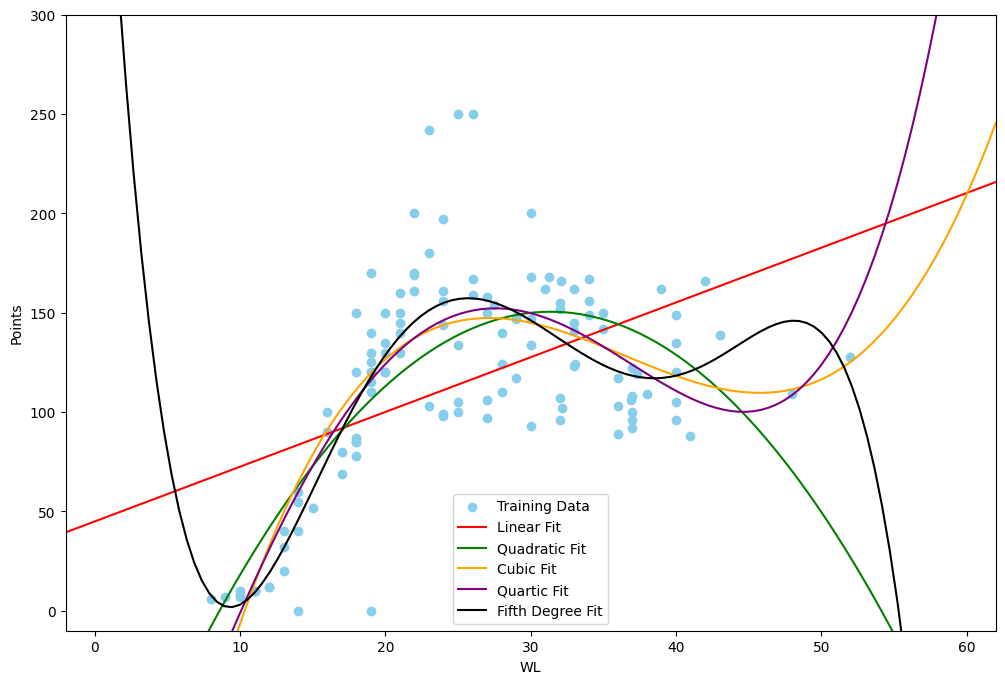

In [124]:
plt.scatter(X_train["WL"], y_train, color="skyblue", label="Training Data")
plt.plot(values, linear_poly(values), color="red", label="Linear Fit")
plt.plot(values, quadratic_poly(values), color="green", label="Quadratic Fit")
plt.plot(values, cubic_poly(values), color="orange", label="Cubic Fit")
plt.plot(values, quartic_poly(values), color="purple", label="Quartic Fit")
plt.plot(values, fifth_poly(values), color="black", label="Fifth Degree Fit")

plt.ylim(y_train.min() - 10, y_train.max() + 50)
plt.xlim(X_train["WL"].min() - 10, X_train["WL"].max() + 10)
plt.xlabel("WL")
plt.ylabel("Points")
plt.legend()

plt.show()

##### Polynomial features over all features

In [280]:
polynomial_converter = PolynomialFeatures(degree=2, include_bias=False)
polynomial_converter.fit(X_train)

PolynomialFeatures(include_bias=False)

In [281]:
features = polynomial_converter.get_feature_names_out(input_features=X_train.columns)
features = [feat.replace(" ", "_") for feat in features]
X_train_poly = pd.DataFrame(data=polynomial_converter.fit_transform(X_train), columns=features, index=X_train.index)
X_train_poly

,WL,Yoga,Laps,WI,PAFS,Team_Clippers,Team_Lakers,Team_Porcupines,Team_Trailblazers,Team_Warriors,...,Team_Lakers^2,Team_Lakers_Team_Porcupines,Team_Lakers_Team_Trailblazers,Team_Lakers_Team_Warriors,Team_Porcupines^2,Team_Porcupines_Team_Trailblazers,Team_Porcupines_Team_Warriors,Team_Trailblazers^2,Team_Trailblazers_Team_Warriors,Team_Warriors^2
56,24.0,21.000000,28.663468,3.422326,8.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,43.0,46.000000,49.000000,3.000000,4.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
123,39.0,32.000000,45.000000,5.000000,5.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
128,30.0,26.000000,35.168711,2.000000,2.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
127,41.0,38.000000,46.857489,5.000000,4.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,24.0,16.000000,29.000000,5.000000,8.000000,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
106,26.0,19.821783,29.789593,3.000000,4.358999,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
14,29.0,22.000000,37.000000,6.000000,4.359124,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
92,21.0,16.000000,24.000000,3.000000,5.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [282]:
model = LinearRegression()
model.fit(X_train_poly, y_train)

LinearRegression()

In [289]:
y_test_pred = model.predict(pd.DataFrame(data=polynomial_converter.transform(X_test), columns=features, index=X_test.index))

In [286]:
model.intercept_

np.float64(-11.38971264643672)

In [287]:
model.coef_

array([  33.8703014 ,   12.13240903,  -54.68784786,  192.91578762,
         -1.77203394,    4.10463256,  -56.81085414,  272.12005679,
          5.5586724 , -112.92907565,    7.002109  ,   -1.1857204 ,
        -12.04074894,   -2.59404288,   -4.53063661,   16.14991214,
         63.57532772,  -14.74168479,    9.30411182,   28.09007017,
          0.69534575,   -1.28155194,    6.88845335,   -0.61870003,
         18.51828905,    2.63535515,   26.41736507,   13.36718329,
        -10.80080745,    7.29711205,  -16.18690274,    6.16506999,
        -30.25404246,  -39.73691154,  -31.98504133,  -15.12989537,
          6.69969278,   35.38975347,   -8.70410977,  102.51400236,
        -32.46194464,  266.19481499,   34.43865835,  -65.72631149,
         -0.75762599,  -31.22983224,  -23.9346733 ,  -51.62283459,
         -9.15818235,  -15.41551315,    4.10463256,    0.        ,
          0.        ,    0.        ,    0.        ,  -56.81085414,
          0.        ,    0.        ,    0.        ,  272.12005

In [288]:
lr_poly = sm.OLS(y_train, sm.add_constant(X_train_poly)).fit()
lr_poly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Points   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     5.155
Date:                Tue, 07 Jan 2025   Prob (F-statistic):           1.45e-10
Time:                        07:37:42   Log-Likelihood:                -578.12
No. Observations:                 124   AIC:                             1254.
Df Residuals:                      75   BIC:                             1392.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                               -10.0954     84.409     -0.120      0.905    -178.247     158.056
WL                                   33.8703     44.747      0.757      0.451     -55.271     123.011
Yoga                                 12.1324     24.461      0.496      0.621     -36.596      60.860
Laps                                -54.6878     44.898     -1.218      0.227    -144.128      34.753
WI                                  191.6215     63.898      2.999      0.004      64.331     318.912
PAFS                                 -1.7720     17.252     -0.103      0.918     -36.139      32.595
Team_Clippers                         4.1184     33.512      0.123      0.903     -62.641      70.878
Team_Lakers                         -57.4580     64.329     -0.893      0.375    -185.607      70.691
Team_Porcupines                     271.4729    183.705      1.478      0.144     -94.487     637.433
Team_Trailblazers                     4.9115     55.674      0.088      0.930    -105.997     115.820
Team_Warriors                      -113.5762     64.462     -1.762      0.082    -241.991      14.839
WL^2                                  7.0021      6.954      1.007      0.317      -6.850      20.854
WL_Yoga                              -1.1857      3.038     -0.390      0.697      -7.237       4.866
WL_Laps                             -12.0407     13.650     -0.882      0.381     -39.234      15.152
WL_WI                                -2.5940     17.440     -0.149      0.882     -37.336      32.148
WL_PAFS                              -4.5306      3.187     -1.422      0.159     -10.879       1.818
WL_Team_Clippers                     16.4858     72.936      0.226      0.822    -128.811     161.782
WL_Team_Lakers                       63.5753     50.675      1.255      0.214     -37.374     164.525
WL_Team_Porcupines                  -14.7417     92.088     -0.160      0.873    -198.190     168.706
WL_Team_Trailblazers                  9.3041     47.011      0.198      0.844     -84.346     102.954
WL_Team_Warriors                     28.0901     66.611      0.422      0.674    -104.606     160.786
Yoga^2                                0.6953      0.479      1.451      0.151      -0.260       1.650
Yoga_Laps                            -1.2816      3.288     -0.390      0.698      -7.831       5.268
Yoga_WI                               6.8885      4.154      1.658      0.101      -1.386      15.163
Yoga_PAFS                            -0.6187      0.715     -0.865      0.390      -2.043       0.806
Yoga_Team_Clippers                   18.6006     26.614      0.699      0.487     -34.418      71.619
Yoga_Team_Lakers                      2.6354     26.363      0.100      0.921     -49.883      55.154
Yoga_Team_Porcupines   

In [290]:
y_pred = lr_poly.predict(sm.add_constant(polynomial_converter.transform(X_test)))
y_pred

array([146.01666181, 110.6055196 ,  75.05986943,  94.87875505,
       151.24324438, 178.78211719, 179.03916056, 112.37097752,
       138.22980363,  76.1095602 , 132.26273813,  66.16197219,
       149.938503  ,  64.62246161, 136.60441881, 130.81984125,
       119.53258084, 159.07843276,   4.85263507, 121.32544702,
       156.51623795, 143.64425685, 143.67815642, 171.48596691,
       109.09941201, 152.61778415, 109.3758618 ,  98.        ,
       141.74187705, 180.70160734, 105.04964515,   6.79412474])

In [291]:
y_test_pred

array([146.01666181, 110.6055196 ,  75.05986943,  94.87875505,
       151.24324438, 178.78211719, 179.03916056, 112.37097752,
       138.22980363,  76.1095602 , 132.26273813,  66.16197219,
       149.938503  ,  64.62246161, 136.60441881, 130.81984125,
       119.53258084, 159.07843276,   4.85263507, 121.32544702,
       156.51623795, 143.64425685, 143.67815642, 171.48596691,
       109.09941201, 152.61778415, 109.3758618 ,  98.        ,
       141.74187705, 180.70160734, 105.04964515,   6.79412474])

In [292]:
root_mean_squared_error(y_test, y_pred) # root mean squared error for polynomial regression model using statsmodels api

np.float64(38.32321264100268)

In [293]:
root_mean_squared_error(y_test, y_test_pred) # root mean squared error for polynomial regression model using sklearn api

np.float64(38.32321264096607)

In [242]:
r2_score(y_test, y_pred) # R^2 score for polynomial regression model using statsmodels api

0.365182879173946

In [243]:
r2_score(y_test, y_test_pred) # R^2 score for polynomial regression model using sklearn api

0.3651828791751587